<a href="https://colab.research.google.com/github/AnchitSharma/churn_customer_prediction/blob/master/Telco_churn_predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve



In [2]:
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1KSPG5EteoKDiOgRg3Ath2ziiiG_9ThCsSWIt-rcf2NY')


In [3]:
sheets = gsheets.worksheet('WA_Fn-UseC_-Telco-Customer-Churn.xls').get_all_values()
df = pd.DataFrame(sheets[1:], columns=sheets[0])

In [4]:
df.head()

customerID  gender SeniorCitizen Partner Dependents tenure PhoneService  \
0  7590-VHVEG  Female             0     Yes         No      1           No   
1  5575-GNVDE    Male             0      No         No     34          Yes   
2  3668-QPYBK    Male             0      No         No      2          Yes   
3  7795-CFOCW    Male             0      No         No     45           No   
4  9237-HQITU  Female             0      No         No      2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges Churn  
0           Electronic check          29.85        29.85    No  
1               Mailed check          56.95       1889.5    No  
2               Mailed check          53.85       108.15   Yes  
3  Bank transfer (automatic)           42.3      1840.75    No  
4           Electronic check           70.7       151.65   Yes  

[5 rows x 21 columns]

In [5]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [6]:
df = df.dropna(how="all")
df = df[~df.duplicated()]
df[df['TotalCharges']==''].shape

(11, 21)

In [7]:
def get_blank_count(df):
  for c in df.columns:
    if df[c].dtype == object:
      print(c, " : ",df[df[c] == ''].shape[0])


In [8]:
print("Print null values :", df[df["TotalCharges"].isnull()].shape)
get_blank_count(df)


Print null values : (0, 21)
customerID  :  0
gender  :  0
SeniorCitizen  :  0
Partner  :  0
Dependents  :  0
tenure  :  0
PhoneService  :  0
MultipleLines  :  0
InternetService  :  0
OnlineSecurity  :  0
OnlineBackup  :  0
DeviceProtection  :  0
TechSupport  :  0
StreamingTV  :  0
StreamingMovies  :  0
Contract  :  0
PaperlessBilling  :  0
PaymentMethod  :  0
MonthlyCharges  :  0
TotalCharges  :  11
Churn  :  0


In [9]:
## remove 11 rows with spaces in TotalCharges column (0.15% missing data)
df.TotalCharges = pd.to_numeric(df.TotalCharges)
df.MonthlyCharges = pd.to_numeric(df.MonthlyCharges)
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)
df = df.dropna(how = 'any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   object 
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [10]:
df.SeniorCitizen = pd.to_numeric(df.SeniorCitizen)
df.tenure = pd.to_numeric(df.tenure)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


No     5163
Yes    1869
Name: Churn, dtype: int64


Text(0.5, 1.0, 'Churn')

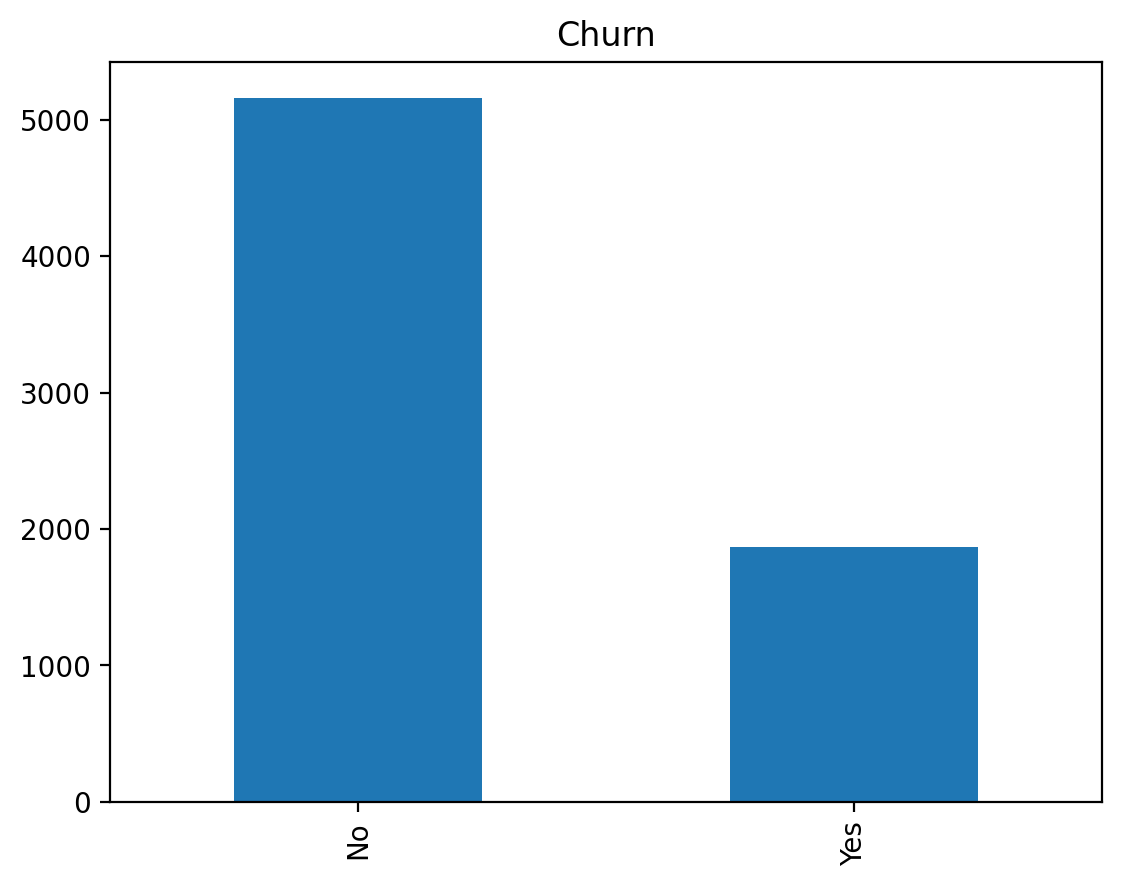

In [11]:
# Target variable distribution is not balanced.
print(df['Churn'].value_counts())
df['Churn'].value_counts().plot(kind='bar').set_title('Churn')

In [12]:
# percentage of churn customers
1869/(5163+1869)

0.26578498293515357

In [13]:
# see all numerical columns
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [14]:
# replace values of senior citizen into categorical feature
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0:'No'})
df.describe()

tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

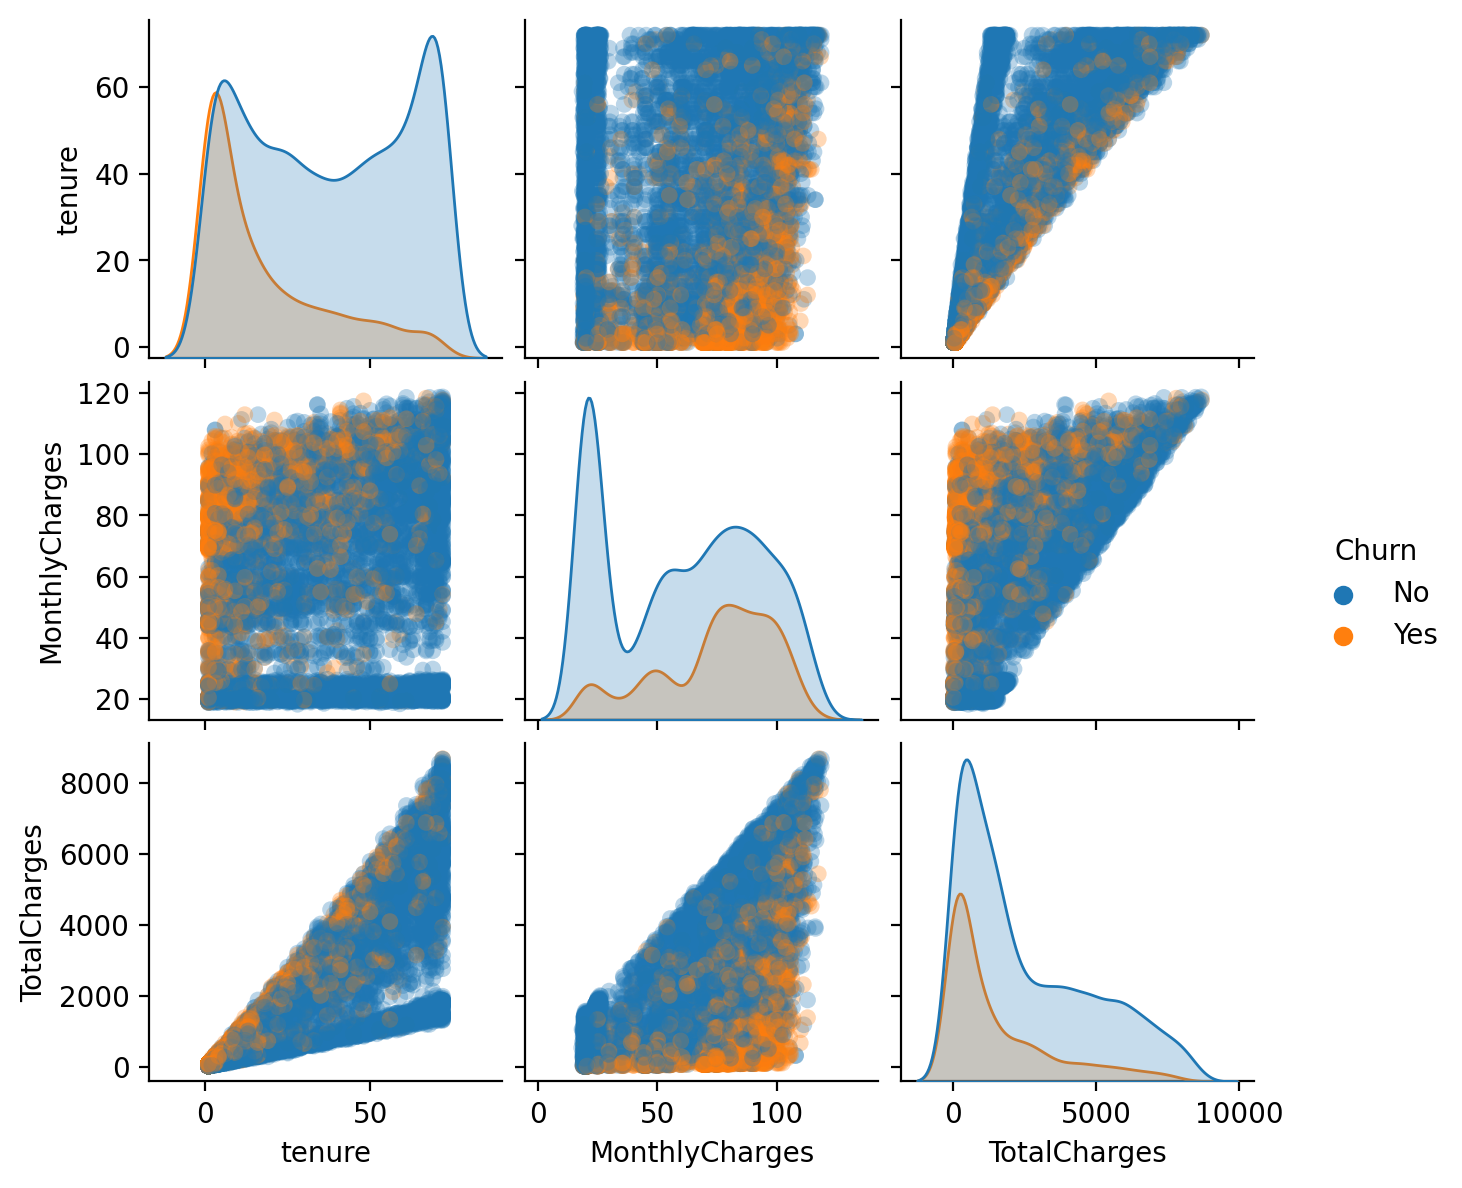

In [15]:
# plt.figure(figsize=(15, 15))
sns.pairplot(
    df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']],
    hue = 'Churn',
    plot_kws=dict(alpha=0.3, edgecolor='none'),
    height=2,
    aspect=1.1
)
# plt.show()

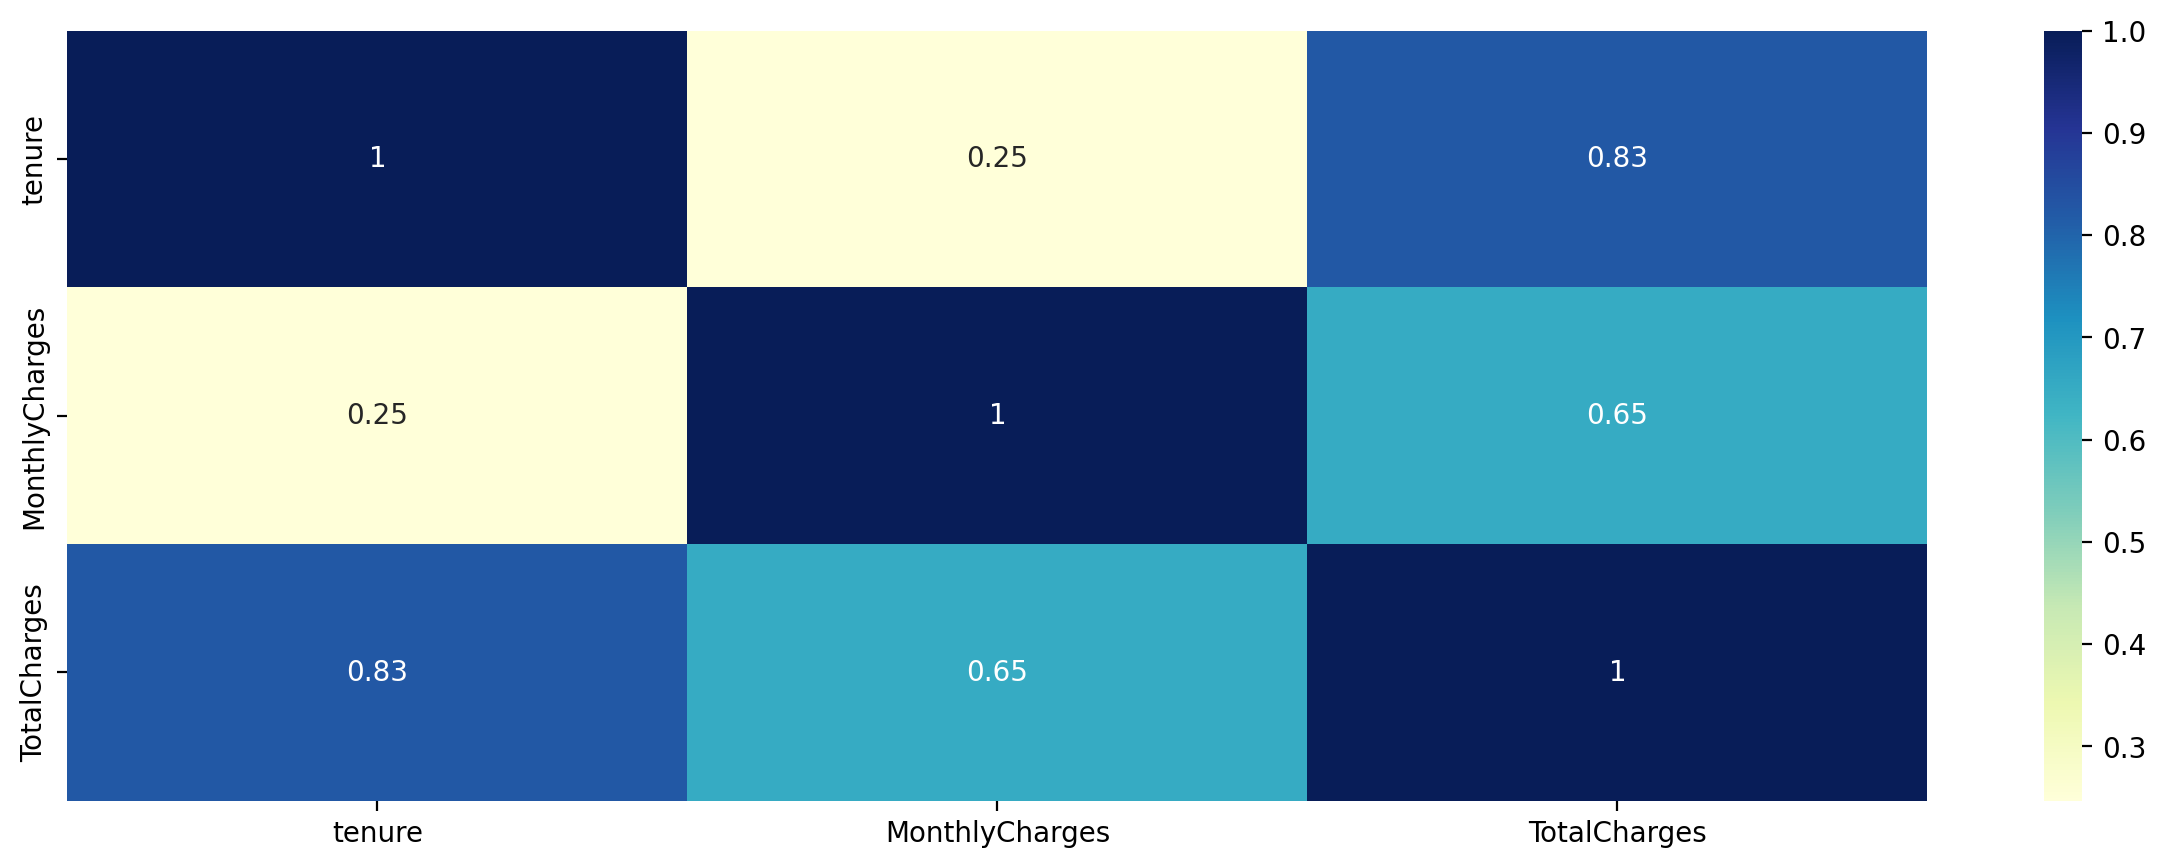

In [16]:
# correlation matrix for variables
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

array([<Axes: title={'center': 'tenure'}>,
       <Axes: title={'center': 'MonthlyCharges'}>,
       <Axes: title={'center': 'TotalCharges'}>], dtype=object)

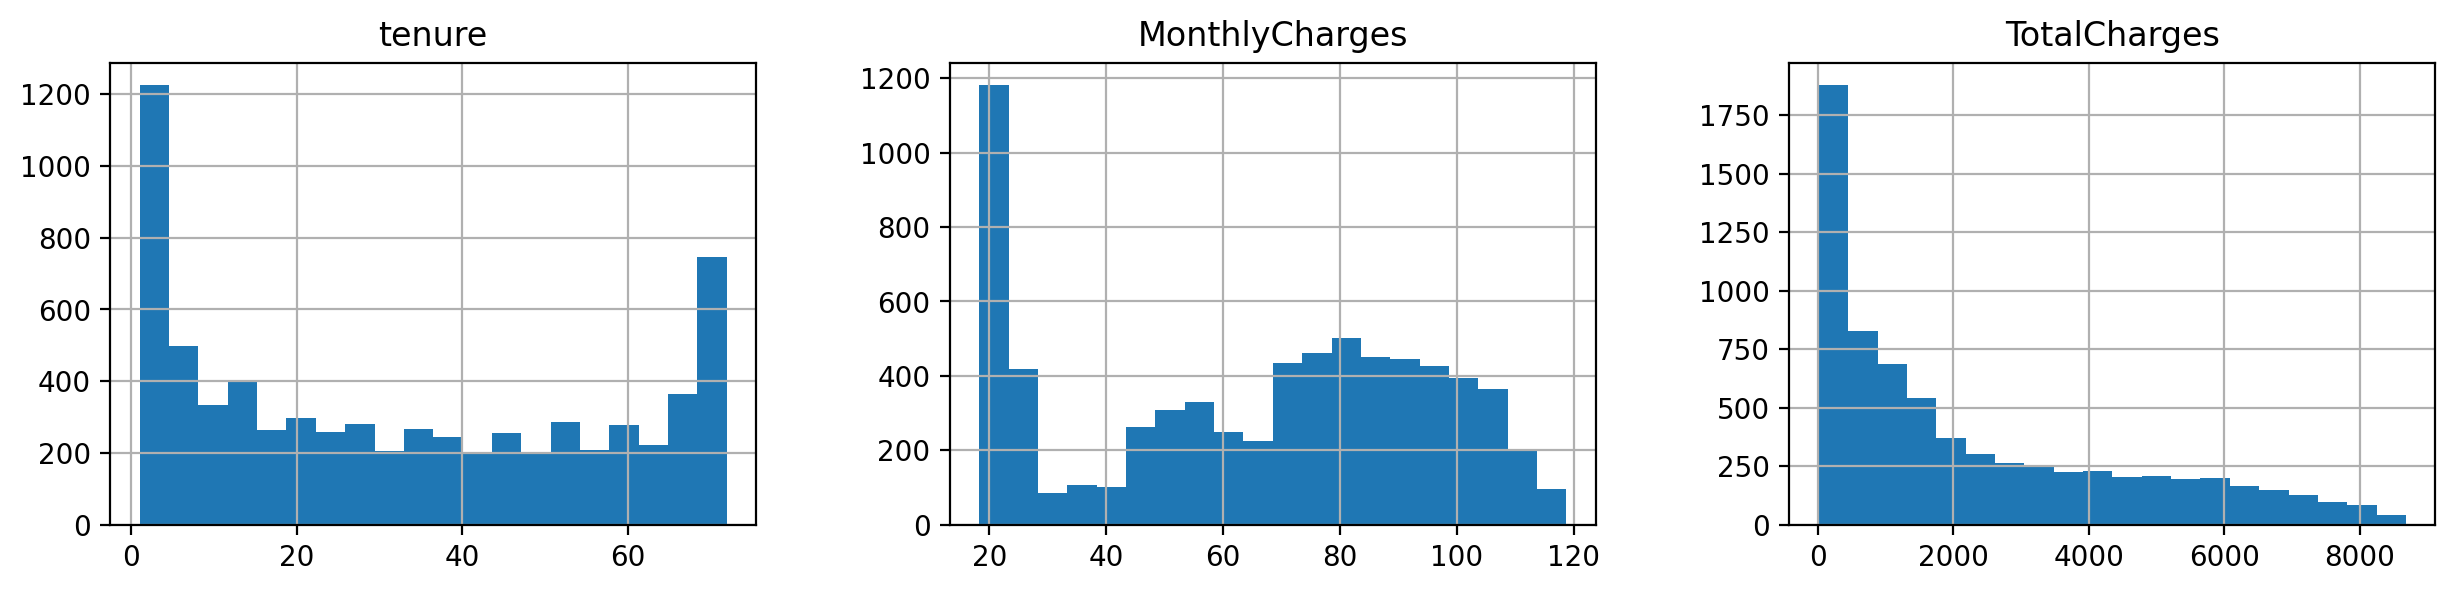

In [17]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
# to view numerical features in charts
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[num_cols].hist(bins=20, figsize=(10, 7), ax=ax)

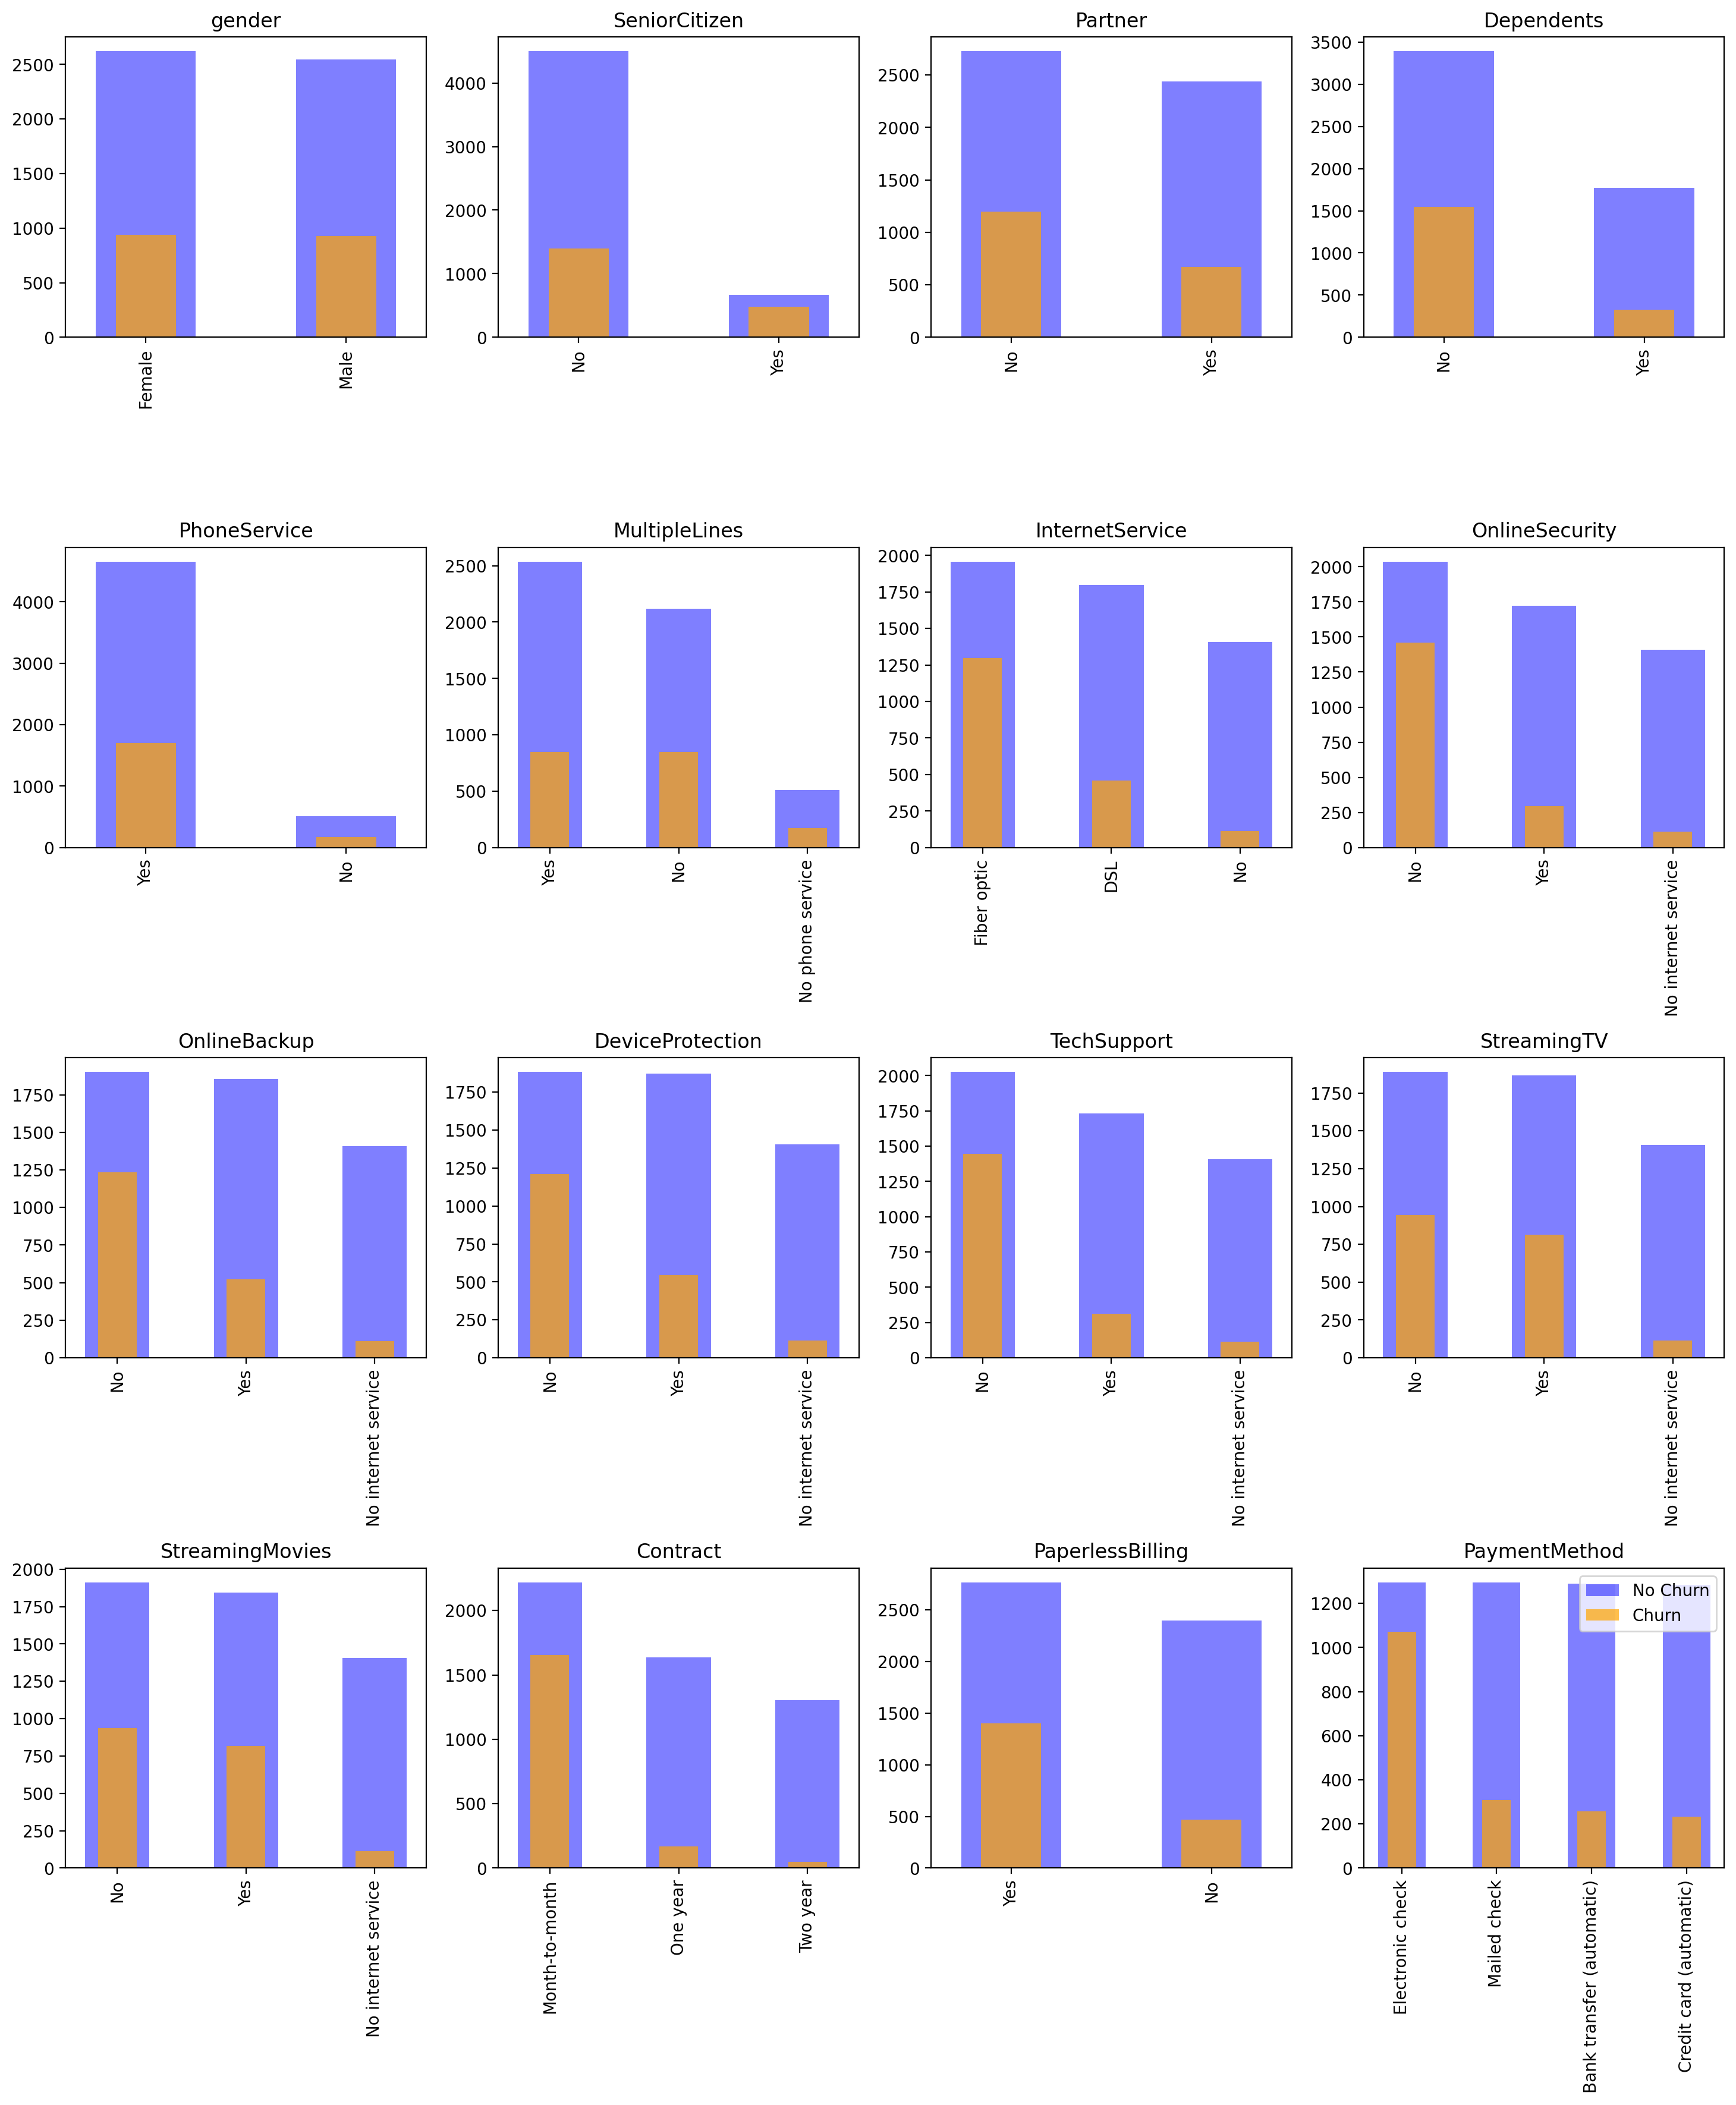

In [18]:
categorical_features = []

for c in df.columns:
  if c in ['customerID', 'Churn']:
    continue
  if df[c].dtype == object:
    categorical_features.append(c)

categorical_features
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
  if col == COLS - 1:
    row += 1
  col = i % COLS
  df[df.Churn=='No'][categorical_feature].value_counts().plot(kind ='bar', width=.5, ax= ax[row,col], color='blue', alpha=0.5).set_title(categorical_feature)
  df[df.Churn=='Yes'][categorical_feature].value_counts().plot(kind = 'bar', width=.3, ax= ax[row,col], color='orange', alpha=0.7).set_title(categorical_feature)
  plt.legend(['No Churn', 'Churn'])
  fig.subplots_adjust(hspace=0.7)

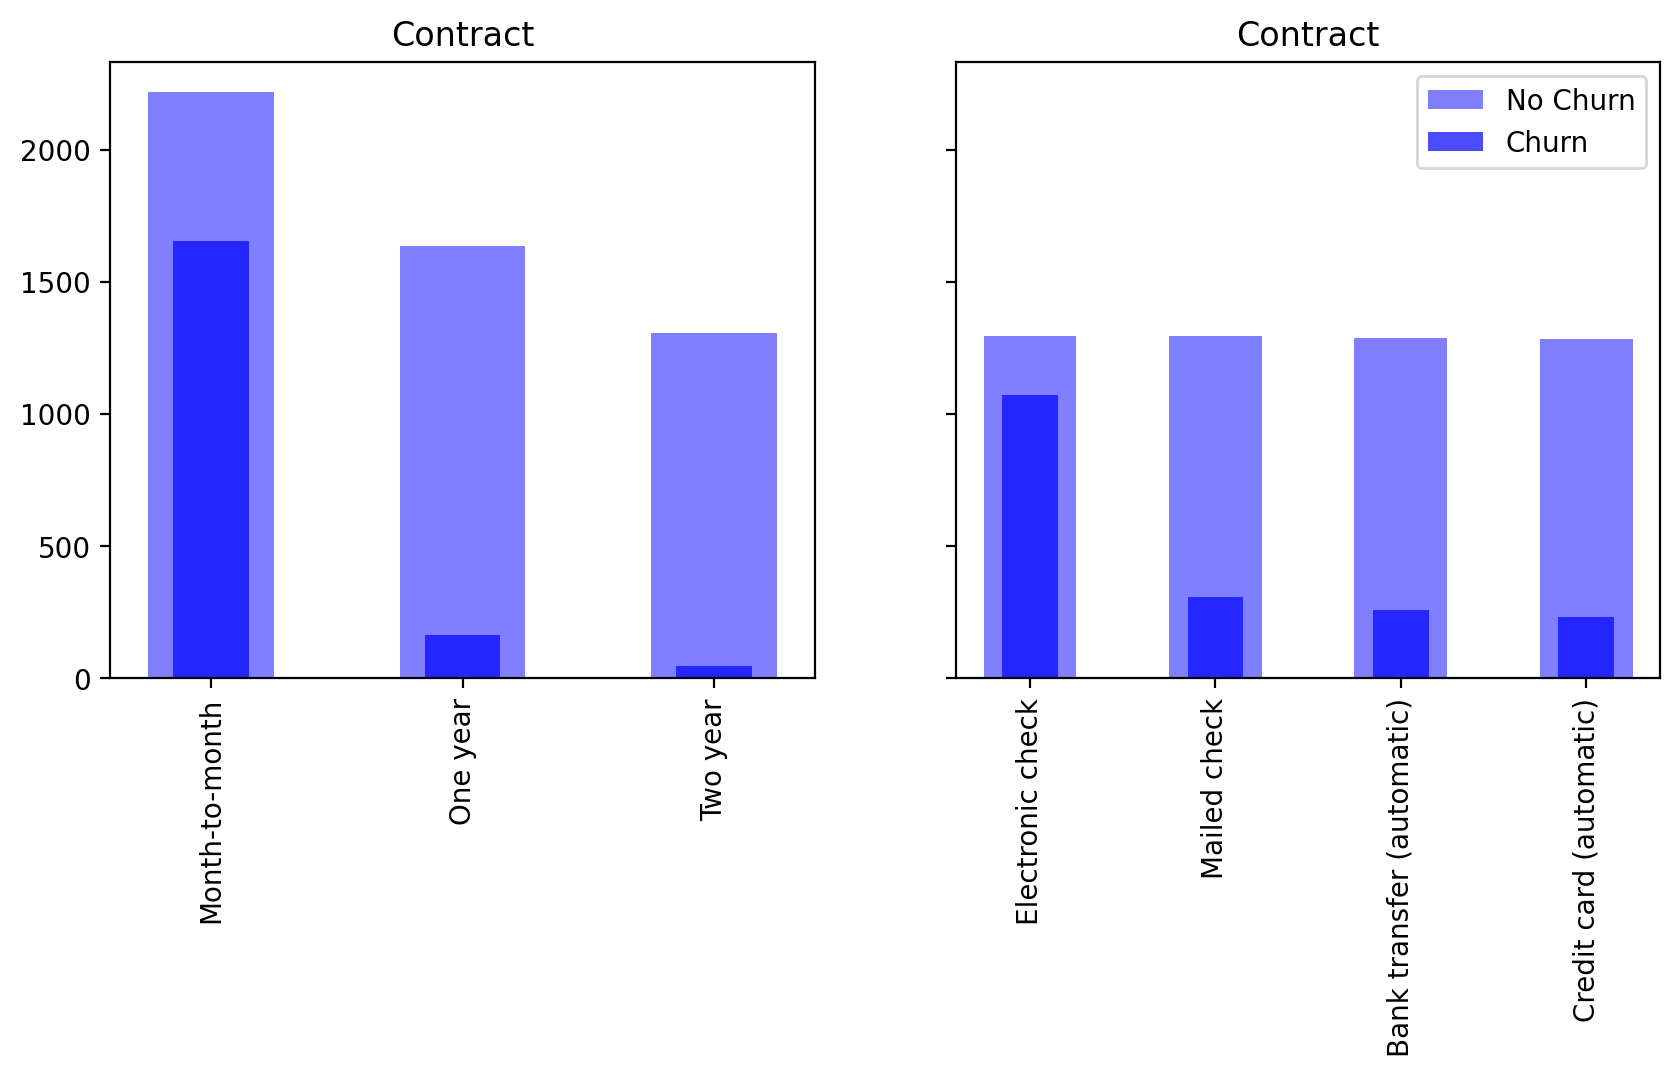

In [19]:
# to look at Contract & Payment Method in relation to the target variable
# note: users who have a month-to-month contract and Electronic check PaymentMethod are more likely to churn

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
df[df['Churn']=='No']['Contract'].value_counts().plot(kind='bar', ax=ax[0], color='blue', alpha=0.5).set_title('Contract')
df[df['Churn']=='Yes']['Contract'].value_counts().plot(kind='bar', width=0.3,ax=ax[0], color='blue', alpha=0.7).set_title('Contract')

df[df['Churn']=='No']['PaymentMethod'].value_counts().plot(kind='bar', ax=ax[1], color='blue', alpha=0.5).set_title('Contract')
df[df['Churn']=='Yes']['PaymentMethod'].value_counts().plot(kind='bar', width=0.3,ax=ax[1], color='blue', alpha=0.7).set_title('Contract')
plt.legend(['No Churn', 'Churn'])


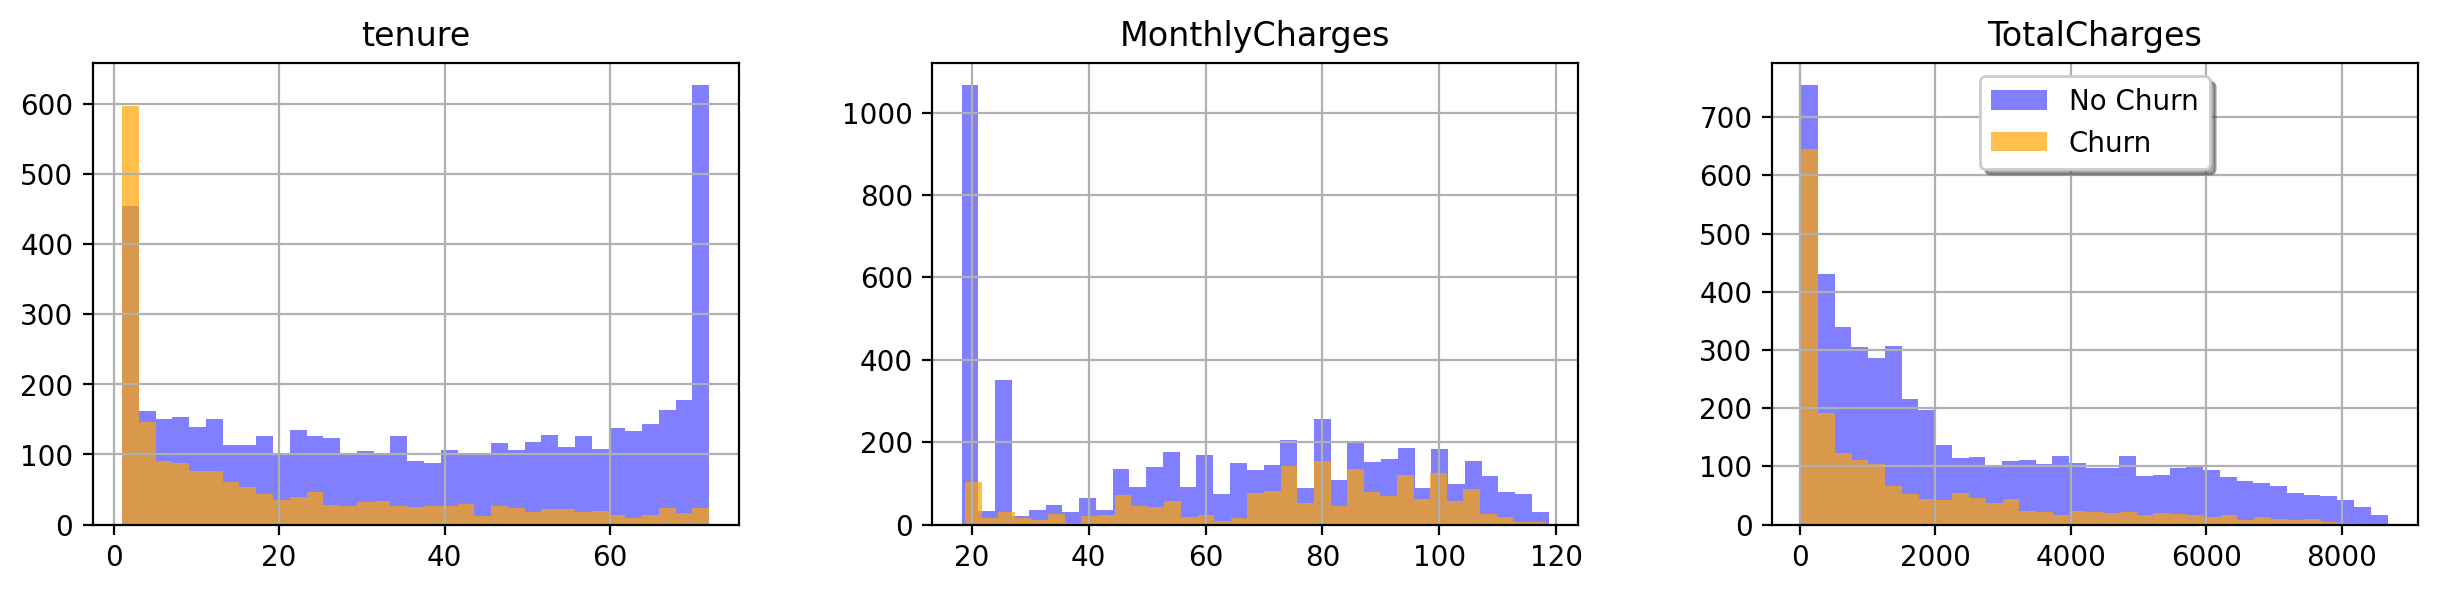

In [20]:
# look at distribution of numerical features in relation to the target variable
# the greater TotalCharges and tenure are the less is the possibility of churn

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[df['Churn'] == "No"][num_cols].hist(bins= 35, color="blue", alpha=0.5, ax=ax)
df[df['Churn'] == "Yes"][num_cols].hist(bins= 35, color="orange", alpha=0.7, ax=ax)
plt.legend(["No Churn", "Churn"], shadow=True, loc=9)

In [21]:
# change MonthlyCharges to categorical column
def monthlycharges_split(df):
  if df['MonthlyCharges'] <= 30:
    return '0-30'
  elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] < 70):
    return '30-70'
  elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] < 99):
    return '70-99'
  elif df['MonthlyCharges'] > 99:
    return '99plus'

df['monthlycharges_group'] = df.apply(lambda df : monthlycharges_split(df), axis = 1)

def totalcharges_split(df):
  if df['TotalCharges'] <= 2000:
    return '0-2k'
  elif (df['TotalCharges'] > 2000) & (df['TotalCharges'] <= 4000):
    return '2-4k'
  elif (df['TotalCharges'] > 4000) & (df['TotalCharges'] <= 6000):
    return '4-6k'
  elif df['TotalCharges'] > 6000:
    return '6kplus'
df['totalcharges_group'] = df.apply(lambda df: totalcharges_split(df), axis=1)

def tenure_split(df):
  if df['tenure'] <= 20:
    return '0-20'
  elif (df['tenure'] > 20) & (df['tenure'] <= 40):
    return '20-40'
  elif (df['tenure'] > 40) & (df['tenure'] <= 60):
    return '40-60'
  elif df['tenure'] > 60:
    return '60plus'

df['tenure_group'] = df.apply(lambda df: tenure_split(df), axis = 1)

<Axes: title={'center': 'monthlycharges_group'}>

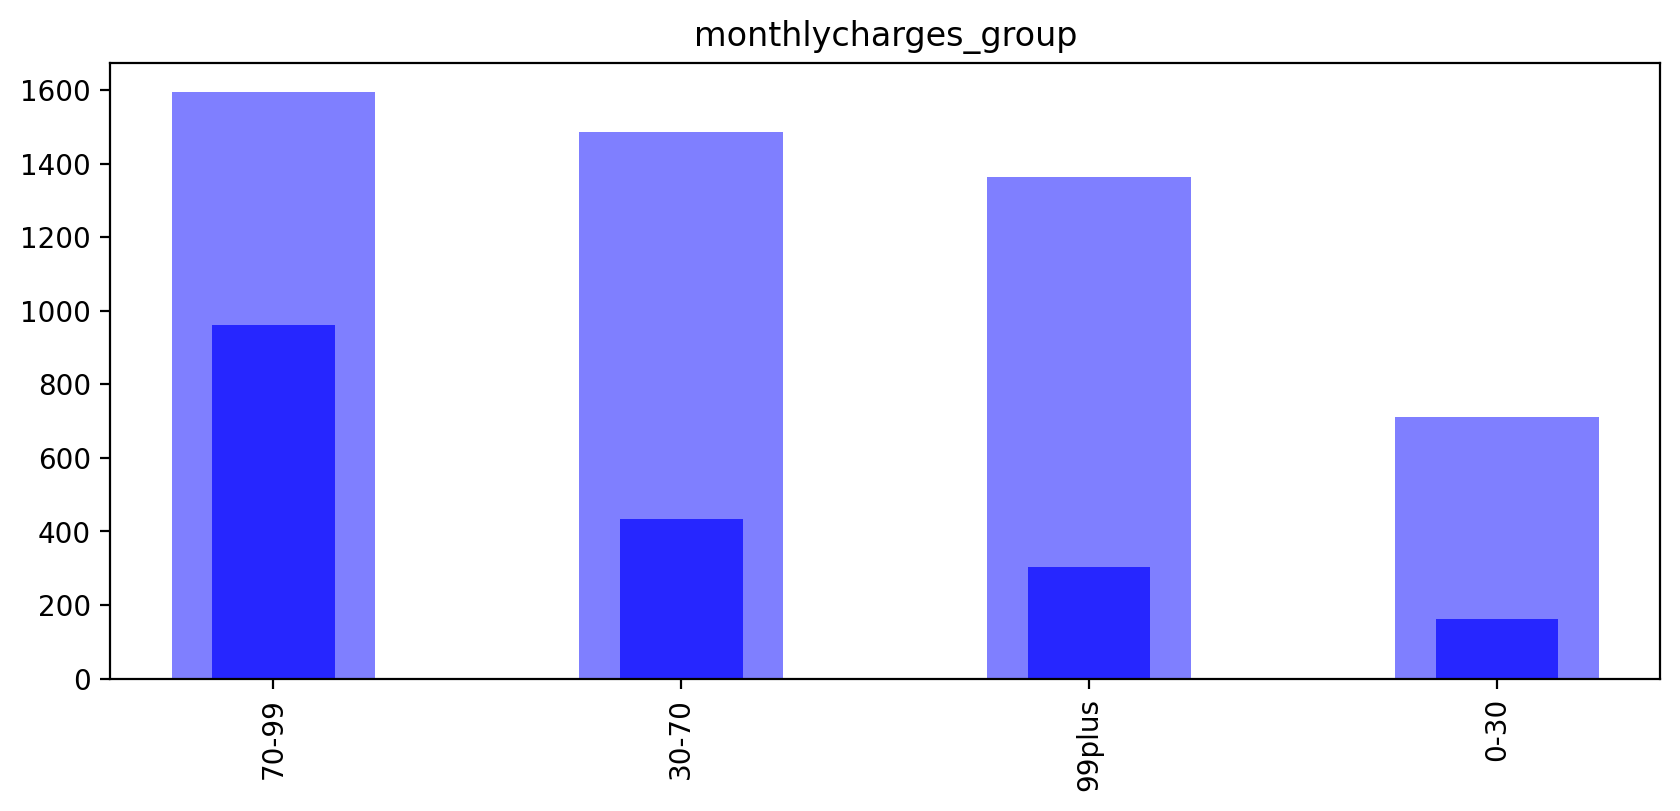

In [22]:
plt.figure(figsize=(10, 4))
df[df['Churn']=='No']['monthlycharges_group'].value_counts().plot(kind='bar',  color='blue', alpha=0.5).set_title('monthlycharges_group')
df[df['Churn']=='Yes']['monthlycharges_group'].value_counts().plot(kind='bar', width=0.3, color='blue', alpha=0.7)

<Axes: title={'center': 'totalcharges_group'}>

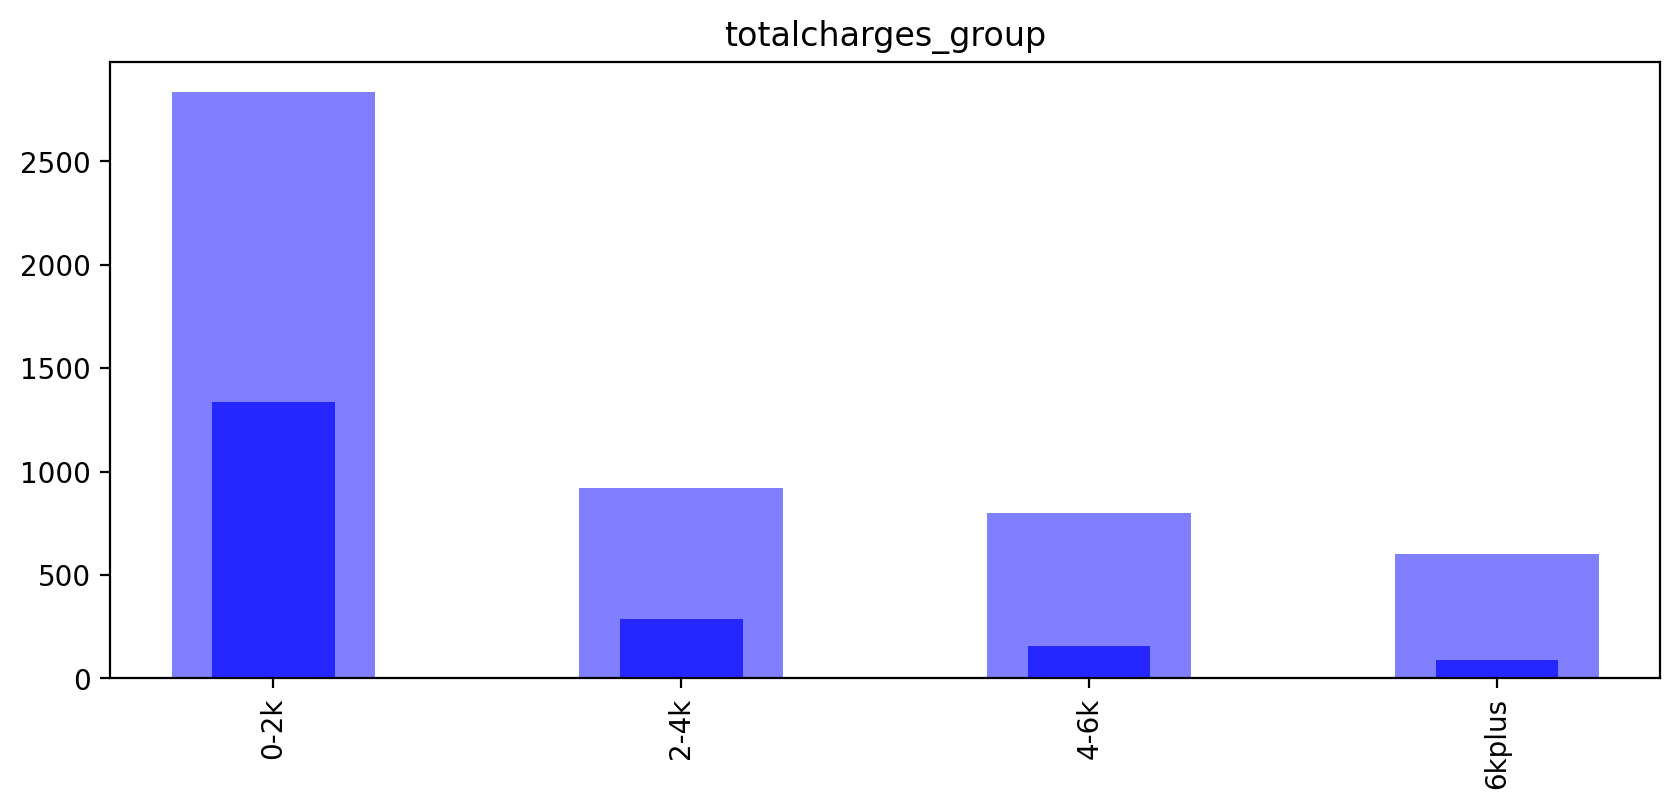

In [23]:
plt.figure(figsize=(10, 4))
df[df['Churn']=='No']['totalcharges_group'].value_counts().plot(kind='bar',  color='blue', alpha=0.5).set_title('totalcharges_group')
df[df['Churn']=='Yes']['totalcharges_group'].value_counts().plot(kind='bar', width=0.3, color='blue', alpha=0.7)

<Axes: title={'center': 'tenure_group'}>

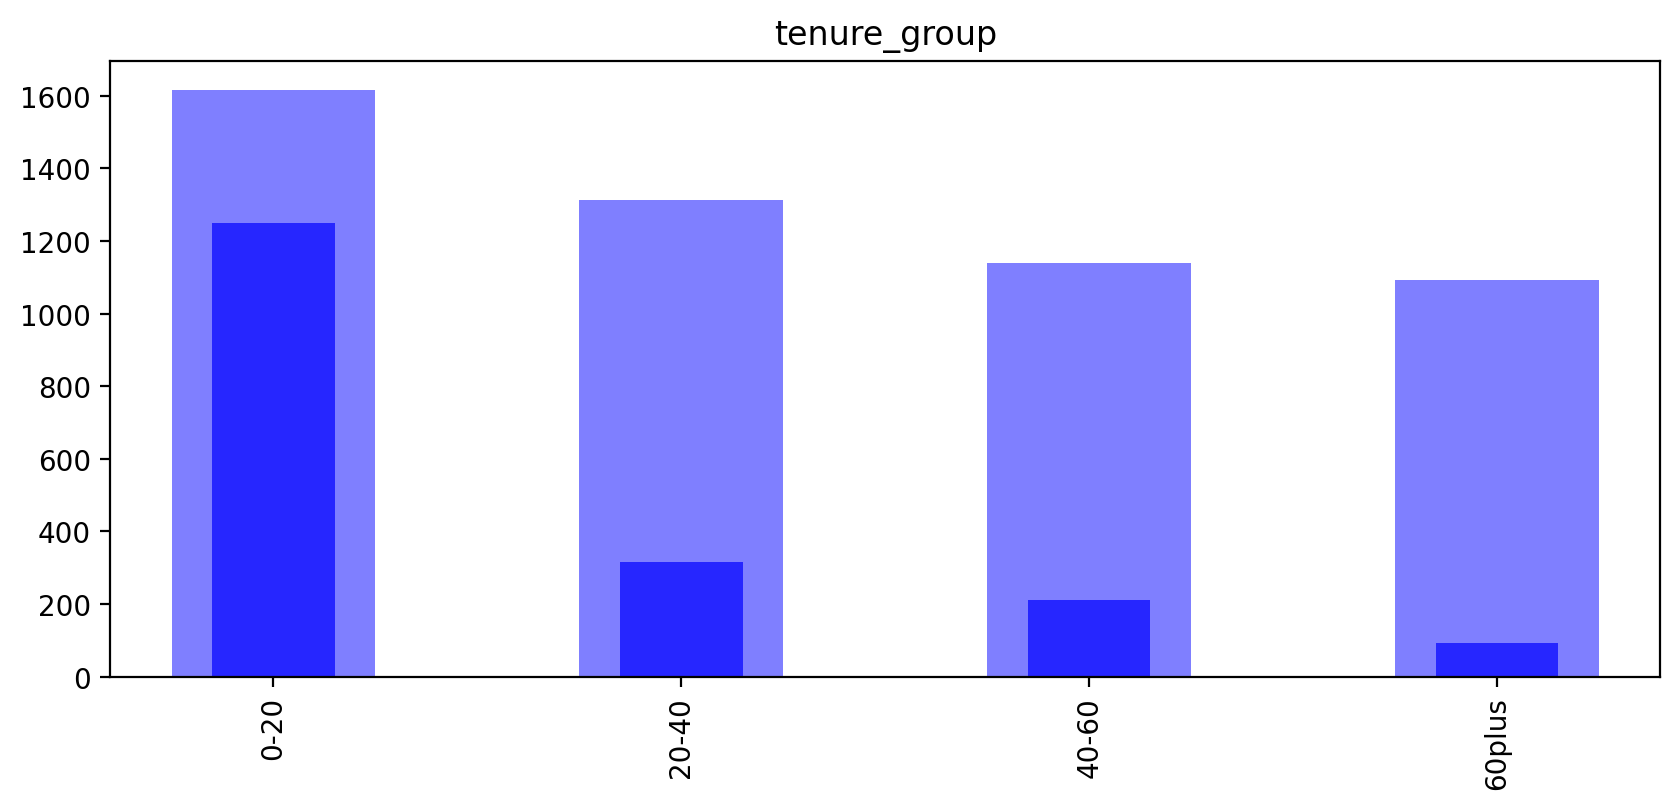

In [24]:
plt.figure(figsize=(10, 4))
df[df['Churn']=='No']['tenure_group'].value_counts().plot(kind='bar',  color='blue', alpha=0.5).set_title('tenure_group')
df[df['Churn']=='Yes']['tenure_group'].value_counts().plot(kind='bar', width=0.3, color='blue', alpha=0.7)

I have to start from cell no. 24

https://github.com/JNYH/Project_McNulty_Churn_Prediction/blob/master/Churn_Prediction.ipynb

In [25]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'monthlycharges_group', 'totalcharges_group', 'tenure_group'],
      dtype='object')

In [26]:
# Data preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# customer id col
Id_col = ['customerID']

# Target col
target_col = ['Churn']

# categorical col
cat_cols = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]

# numerical columns
num_cols = [x for x in df.columns if x not in cat_cols + target_col + Id_col]


# Binary cols with 2 values
bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()

# columns with more 2 unique values
multi_cols = [x for x in cat_cols if x not in bin_cols]


In [27]:
# label encoding binary variables
le = LabelEncoder()
for i in bin_cols:
  df[i] = le.fit_transform(df[i])

In [28]:
# Duplicating columns for multi value columns
df = pd.get_dummies(data =df, columns = multi_cols)


In [29]:
df = df.reset_index(drop=True)

In [30]:
# standard scaler : Scaling numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

# dropping orignal values merging scaled values for numerical columns
df1 = df.drop(columns = num_cols, axis = 1)


In [31]:
df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'P

In [32]:
df1 = df1.merge(scaled, left_index = True, right_index = True, how = 'left'  )

In [33]:
df1[df1['TotalCharges'].isnull()]

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn, MultipleLines_No, MultipleLines_No phone service, MultipleLines_Yes, InternetService_DSL, InternetService_Fiber optic, InternetService_No, OnlineSecurity_No, OnlineSecurity_No internet service, OnlineSecurity_Yes, OnlineBackup_No, OnlineBackup_No internet service, OnlineBackup_Yes, DeviceProtection_No, DeviceProtection_No internet service, DeviceProtection_Yes, TechSupport_No, TechSupport_No internet service, TechSupport_Yes, StreamingTV_No, StreamingTV_No internet service, StreamingTV_Yes, StreamingMovies_No, StreamingMovies_No internet service, StreamingMovies_Yes, Contract_Month-to-month, Contract_One year, Contract_Two year, PaymentMethod_Bank transfer (automatic), PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check, monthlycharges_group_0-30, monthlycharges_group_30-70, monthlycharges_group_70-99, monthlycharges_group_99plus, totalcharges_group_0-2k, totalcharges_group_2-4k, totalcharges_group_4-6k, totalcharges_group_6kplus, tenure_group_0-20, tenure_group_20-40, tenure_group_40-60, tenure_group_60plus, tenure, MonthlyCharges, TotalCharges]
Index: []

[0 rows x 54 columns]

In [34]:
df1.describe()

gender  SeniorCitizen      Partner   Dependents  PhoneService  \
count  7032.000000    7032.000000  7032.000000  7032.000000   7032.000000   
mean      0.504693       0.162400     0.482509     0.298493      0.903299   
std       0.500014       0.368844     0.499729     0.457629      0.295571   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     0.000000      1.000000   
50%       1.000000       0.000000     0.000000     0.000000      1.000000   
75%       1.000000       0.000000     1.000000     1.000000      1.000000   
max       1.000000       1.000000     1.000000     1.000000      1.000000   

       PaperlessBilling        Churn  MultipleLines_No  \
count       7032.000000  7032.000000       7032.000000   
mean           0.592719     0.265785          0.481371   
std            0.491363     0.441782          0.499688   
min            0.000000     0.000000          0.000000   
25%            0.000000     0.000000          0.000000   
50%            1.000000     0.000000          0.000000   
75%            1.000000     1.000000          1.000000   
max            1.000000     1.000000          1.000000   

       MultipleLines_No phone service  MultipleLines_Yes  ...  \
count                     7032.000000        7032.000000  ...   
mean                         0.096701           0.421928  ...   
std                          0.295571           0.493902  ...   
min                          0.000000           0.000000  ...   
25%                          0.000000           0.000000  ...   
50%                          0.000000           0.000000  ...   
75%                          0.000000           1.000000  ...   
max                          1.000000           1.000000  ...   

       totalcharges_group_2-4k  totalcharges_group_4-6k  \
count              7032.000000               7032.00000   
mean                  0.171786                  0.13595   
std                   0.377221                  0.34276   
min                   0.000000                  0.00000   
25%                   0.000000                  0.00000   
50%                   0.000000                  0.00000   
75%                   0.000000                  0.00000   
max                   1.000000                  1.00000   

       totalcharges_group_6kplus  tenure_group_0-20  tenure_group_20-40  \
count                7032.000000        7032.000000         7032.000000   
mean                    0.098407           0.407708            0.200228   
std                     0.297886           0.491443            0.400199   
min                     0.000000           0.000000            0.000000   
25%                     0.000000           0.000000            0.000000   
50%                     0.000000           0.000000            0.000000   
75%                     0.000000           1.000000            0.000000   
max                     1.000000           1.000000            1.000000   

       tenure_group_40-60  tenure_group_60plus        tenure  MonthlyCharges  \
count         7032.000000          7032.000000  7.032000e+03    7.032000e+03   
mean             0.191980             0.200085 -1.126643e-16    6.062651e-17   
std              0.393885             0.400092  1.000071e+00    1.000071e+00   
min              0.000000             0.000000 -1.280248e+00   -1.547283e+00   
25%              0.000000             0.000000 -9.542963e-01   -9.709769e-01   
50%              0.000000             0.000000 -1.394171e-01    1.845440e-01   
75%              0.000000             0.000000  9.199259e-01    8.331482e-01   
max              1.000000             1.000000  1.612573e+00    1.793381e+00   

       TotalCharges  
count  7.032000e+03  
mean  -1.119064e-16  
std    1.000071e+00  
min   -9.990692e-01  
25%   -8.302488e-01  
50%   -3.908151e-01  
75%    6.668271e-01  
max    2.824261e+00  

[8 rows x 53 columns]

In [35]:
df1.dtypes

customerID                                  object
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
PhoneService                                 int64
PaperlessBilling                             int64
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet service             uint8
OnlineBackup_Yes               

In [36]:
# drop customer id column , feature is not needed in model selection
df1 = df1.drop('customerID', axis = 1)

# there are lot of repeated features( no internet services) , so drop them
df1 = df1.drop(columns= ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
                         'DeviceProtection_No internet service', 'TechSupport_No internet service',
                         'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service',
                         ], axis = 1)
df1.shape

(7032, 47)

Feature Selection

In [37]:
X, y = df1.drop('Churn', axis = 1), df1[['Churn']]

In [38]:
import statsmodels.api as sm

In [39]:
X = sm.add_constant(X) # need to add this to define the Intercept
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     90.15
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:38:38   Log-Likelihood:                -2987.2
No. Observations:                7032   AIC:                             6042.
Df Residuals:                    6998   BIC:                             6276.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                   -1.837e+12    1.2e+12     -1.532      0.125   -4.19e+12    5.13e+11
gender                                     -0.0051      0.009     -0.574      0.566      -0.022       0.012
SeniorCitizen                               0.0475      0.013      3.676      0.000       0.022       0.073
Partner                                     0.0031      0.011      0.286      0.775      -0.018       0.024
Dependents                                 -0.0173      0.011     -1.521      0.128      -0.040       0.005
PhoneService                              6.32e+11   4.12e+11      1.532      0.125   -1.77e+11    1.44e+12
PaperlessBilling                            0.0433      0.010      4.375      0.000       0.024       0.063
MultipleLines_No                         6.434e+10    4.2e+10      1.532      0.125    -1.8e+10    1.47e+11
MultipleLines_No phone service           6.963e+11   4.54e+11      1.532      0.125   -1.94e+11    1.59e+12
MultipleLines_Yes                        6.434e+10    4.2e+10      1.532      0.125    -1.8e+10    1.47e+11
InternetService_DSL                      1.091e+11   7.12e+10      1.532      0.125   -3.05e+10    2.49e+11
InternetService_Fiber optic              1.091e+11   7.12e+10      1.532      0.125   -3.05e+10    2.49e+11
InternetService_No                       6.518e+11   4.25e+11      1.532      0.125   -1.82e+11    1.49e+12
OnlineSecurity_No                        1.981e+10   1.29e+10      1.532      0.125   -5.53e+09    4.52e+10
OnlineSecurity_Yes                       1.981e+10   1.29e+10      1.532      0.125   -5.53e+09    4.52e+10
OnlineBackup_No                          6.775e+10   4.42e+10      1.532      0.125   -1.89e+10    1.54e+11
OnlineBackup_Yes                         6.775e+10   4.42e+10      1.532      0.125   -1.89e+10    1.54e+11
DeviceProtection_No                      5.047e+10   3.29e+10      1.532      0.125   -1.41e+10    1.15e+11
DeviceProtection_Yes                     5.047e+10   3.29e+10      1.532      0.125   -1.41e+10    1.15e+11
TechSupport_No                           5.676e+10    3.7e+10      1.532      0.125   -1.59e+10    1.29e+11
TechSupport_Yes                          5.676e+10    3.7e+10      1.532      0.125   -1.59e+10    1.29e+11
StreamingTV_No                             2.8e+11   1.83e+11      1.532      0.125   -7.82e+10    6.38e+11
StreamingTV_Yes                            2.8e+11   1.83e+11      1.532      0.125   -7.82e+10    6.38e+11
StreamingMovies_No                       6.789e+10   4.43e+10      1.532      0.125    -1.9e+10    1.55e+11
StreamingMovies_Yes                      6.789e+10   4.43e+10      1.532      0.125    -1.9e+10    1.55e+11
Contract_Month-to-month                  2.384e+11   1.56e+

In [40]:
### to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures


print("Use LassoCV to find the optimal ALPHA value for L1 Regularization")
std = StandardScaler()
std.fit(X.values)
X_Scaled = std.transform(X.values)
print("X_scaled", X_Scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3, 3, 200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_Scaled, y)
# This is the best alpha value found
print("Lasso best alpha: ", lasso_model.alpha_)
# display all coefficients in the model with optimal alpha
list(zip(X.columns, lasso_model.coef_))

Use LassoCV to find the optimal ALPHA value for L1 Regularization
X_scaled (7032, 47)
Lasso best alpha:  0.001


[('const', 0.0),
 ('gender', -0.00106351211126779),
 ('SeniorCitizen', 0.016431042897109362),
 ('Partner', 0.0),
 ('Dependents', -0.0068801099709186716),
 ('PhoneService', -0.0),
 ('PaperlessBilling', 0.021007787534893522),
 ('MultipleLines_No', -0.01942926931726015),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.00560657237779803),
 ('InternetService_DSL', -0.0),
 ('InternetService_Fiber optic', 0.07441476606280041),
 ('InternetService_No', -0.007935253017298673),
 ('OnlineSecurity_No', 0.024752007127417704),
 ('OnlineSecurity_Yes', -0.0),
 ('OnlineBackup_No', 0.01082540591743206),
 ('OnlineBackup_Yes', -0.0),
 ('DeviceProtection_No', 0.0023788116987691057),
 ('DeviceProtection_Yes', -0.0),
 ('TechSupport_No', 0.024774153610190332),
 ('TechSupport_Yes', -0.0),
 ('StreamingTV_No', -0.0),
 ('StreamingTV_Yes', 0.02030586602983903),
 ('StreamingMovies_No', -0.0),
 ('StreamingMovies_Yes', 0.02012290609546643),
 ('Contract_Month-to-month', 0.046821557350041114),
 ('Cont

In [41]:
plot_feature = X.columns
plot_feature = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'monthlycharges_group_0-30', 'monthlycharges_group_30-70',
       'monthlycharges_group_70-99', 'monthlycharges_group_99plus',
       'totalcharges_group_0-2k', 'totalcharges_group_2-4k',
       'totalcharges_group_4-6k', 'totalcharges_group_6kplus',
       'tenure_group_0-20', 'tenure_group_20-40', 'tenure_group_40-60',
       'tenure_group_60plus', 'tenure', 'MonthlyCharges', 'TotalCharges']

lasso_coeff  = lasso_model.coef_
lasso_coeff = [-0.00106351,  0.01643104,  0.        , -0.00688011,
       -0.        ,  0.02100779, -0.01942927,  0.        ,  0.00560657,
       -0.        ,  0.07441477, -0.00793525,  0.02475201, -0.        ,
        0.01082541, -0.        ,  0.00237881, -0.        ,  0.02477415,
       -0.        , -0.        ,  0.02030587, -0.        ,  0.02012291,
        0.04682156, -0.00201886, -0.        ,  0.        , -0.00060033,
        0.03176758, -0.00145081, -0.02702554, -0.01849108,  0.        ,
        0.02484763, -0.02949817, -0.        ,  0.02123146,  0.03581873,
       -0.        , -0.01246376,  0.02438734,  0.06063266, -0.06056668,
        0.00102276, -0.20952547]
print(len(plot_feature), len(lasso_coeff))

46 46


<Axes: xlabel='lasso_coeff', ylabel='plot_feature'>

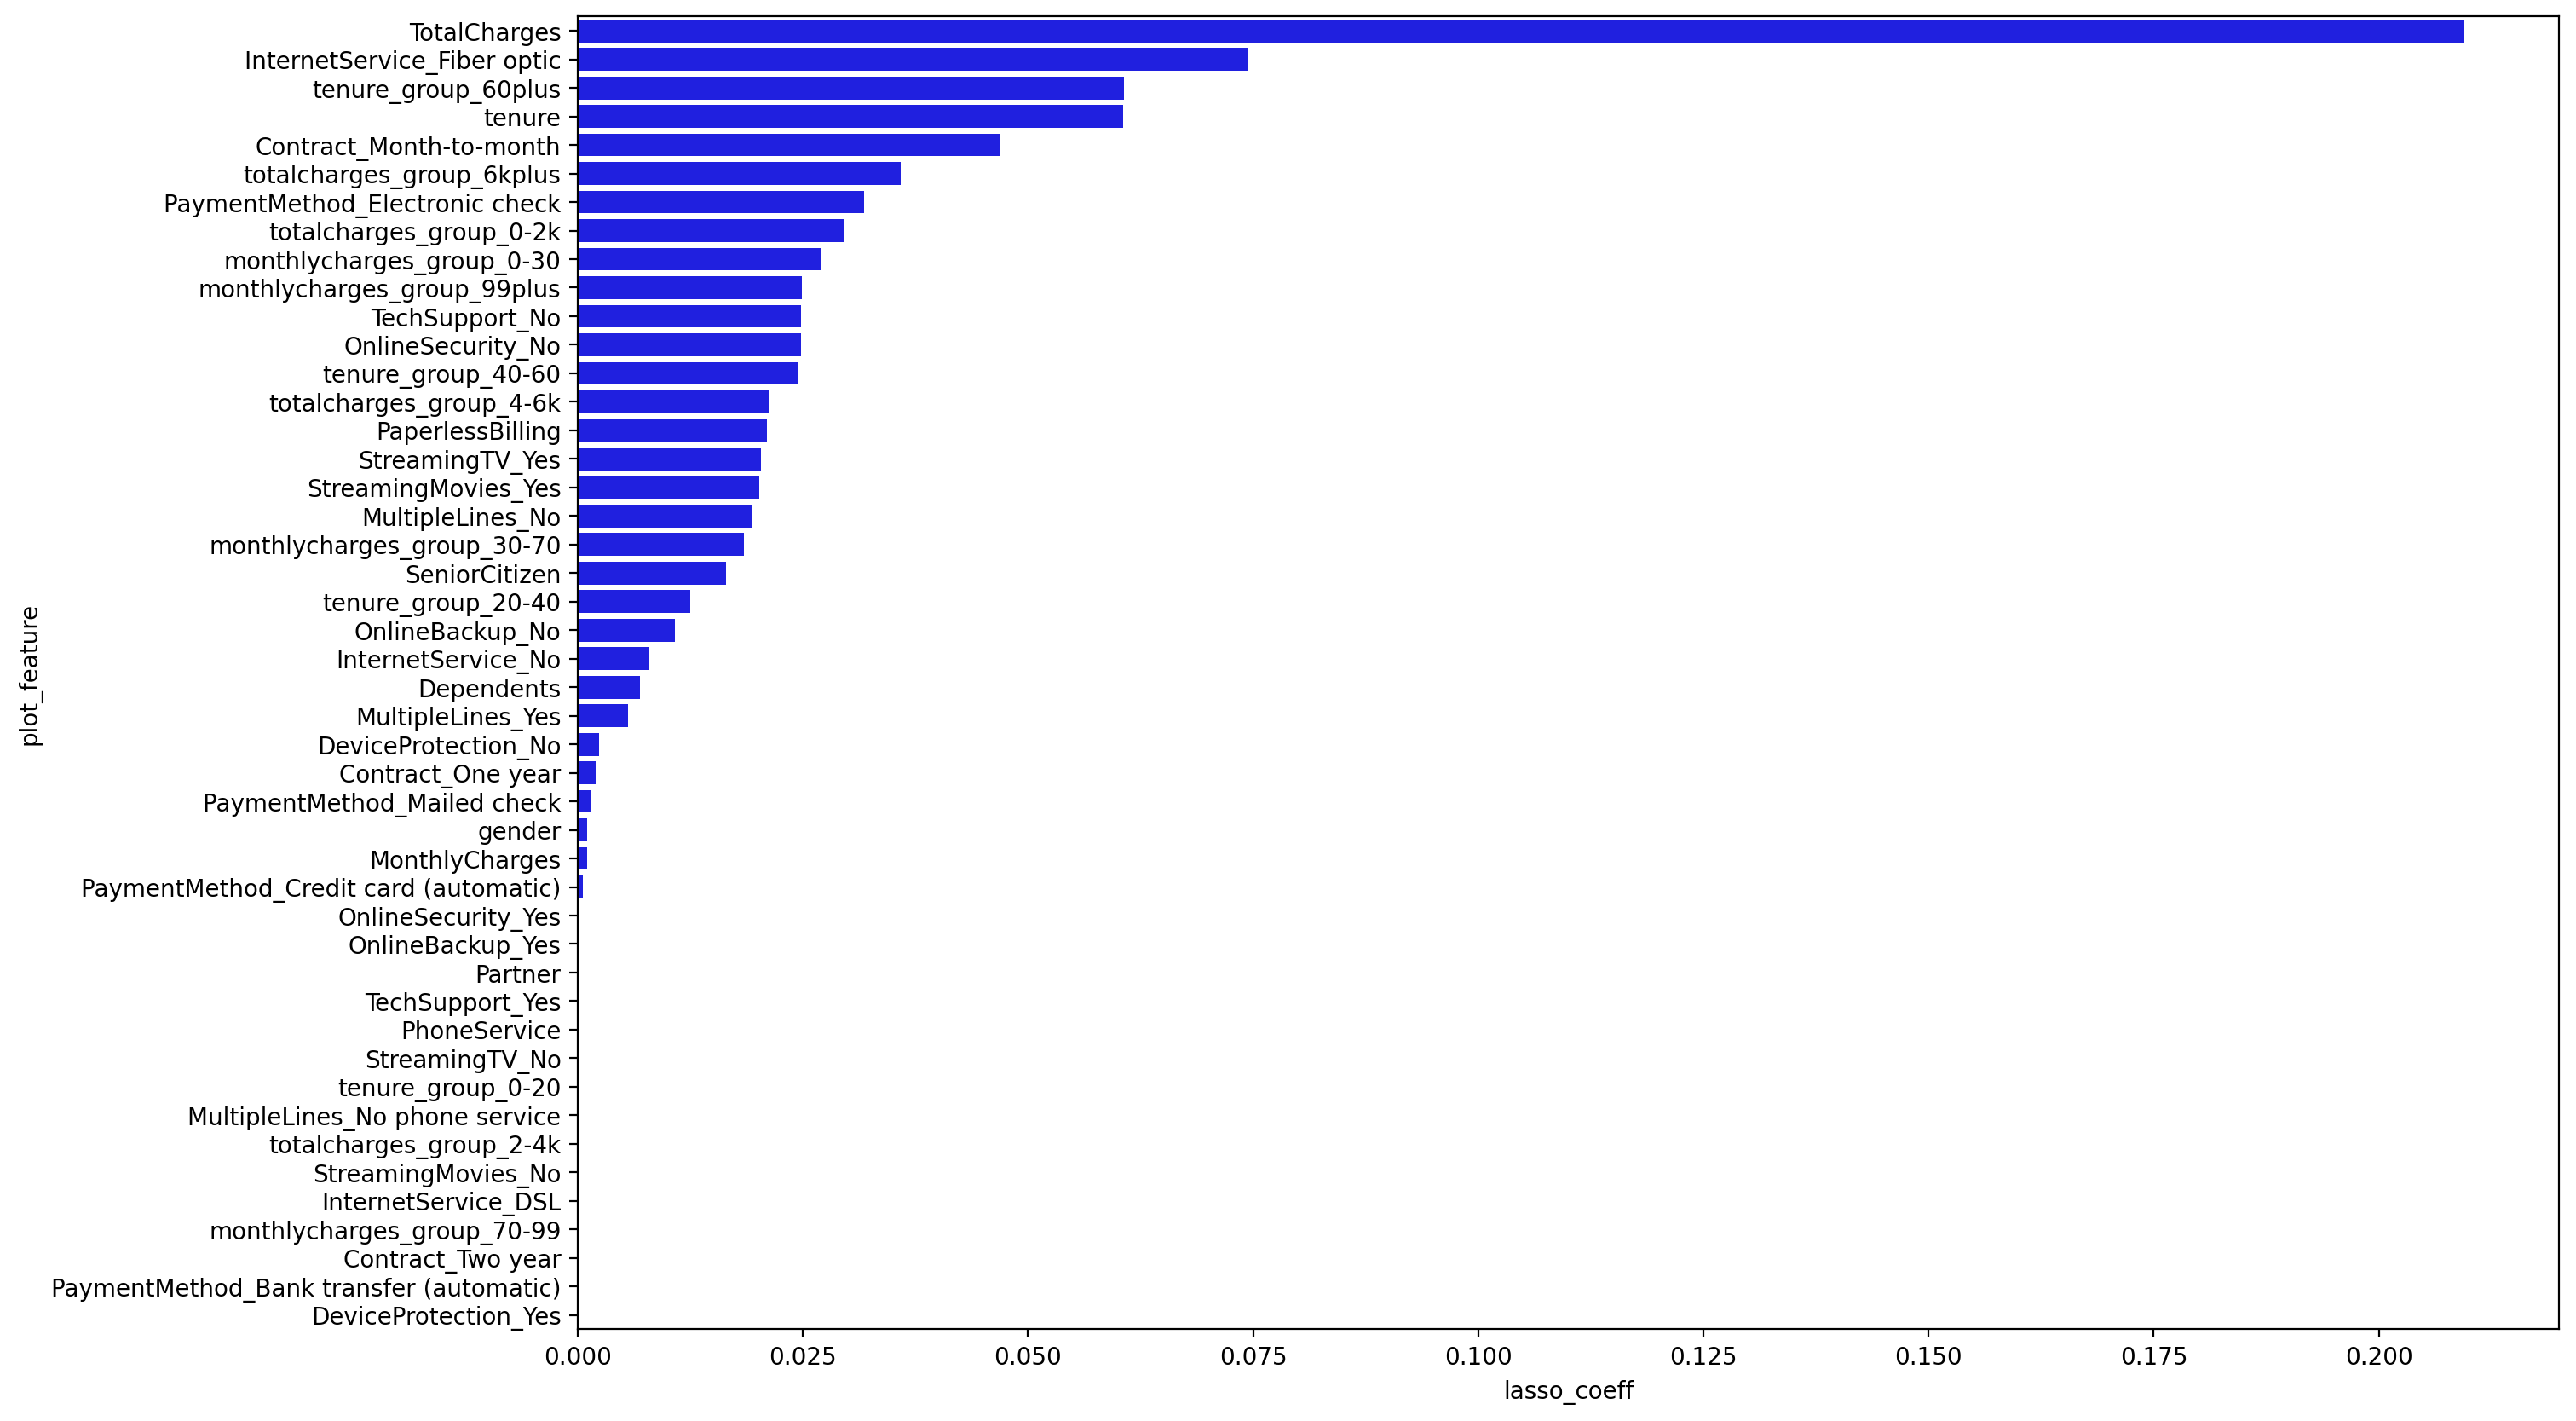

In [42]:
t = pd.DataFrame(
    {
        'plot_feature': plot_feature,
        'lasso_coeff': lasso_coeff
    }
    )

t['lasso_coeff'] = abs(t['lasso_coeff'])
t = t.sort_values('lasso_coeff', ascending = False)
plt.figure(figsize=(15, 10))
sns.barplot(y = t['plot_feature'], x = t['lasso_coeff'], color='b')

Text(0.5, 1.0, 'Top Features derived by Random Forest')

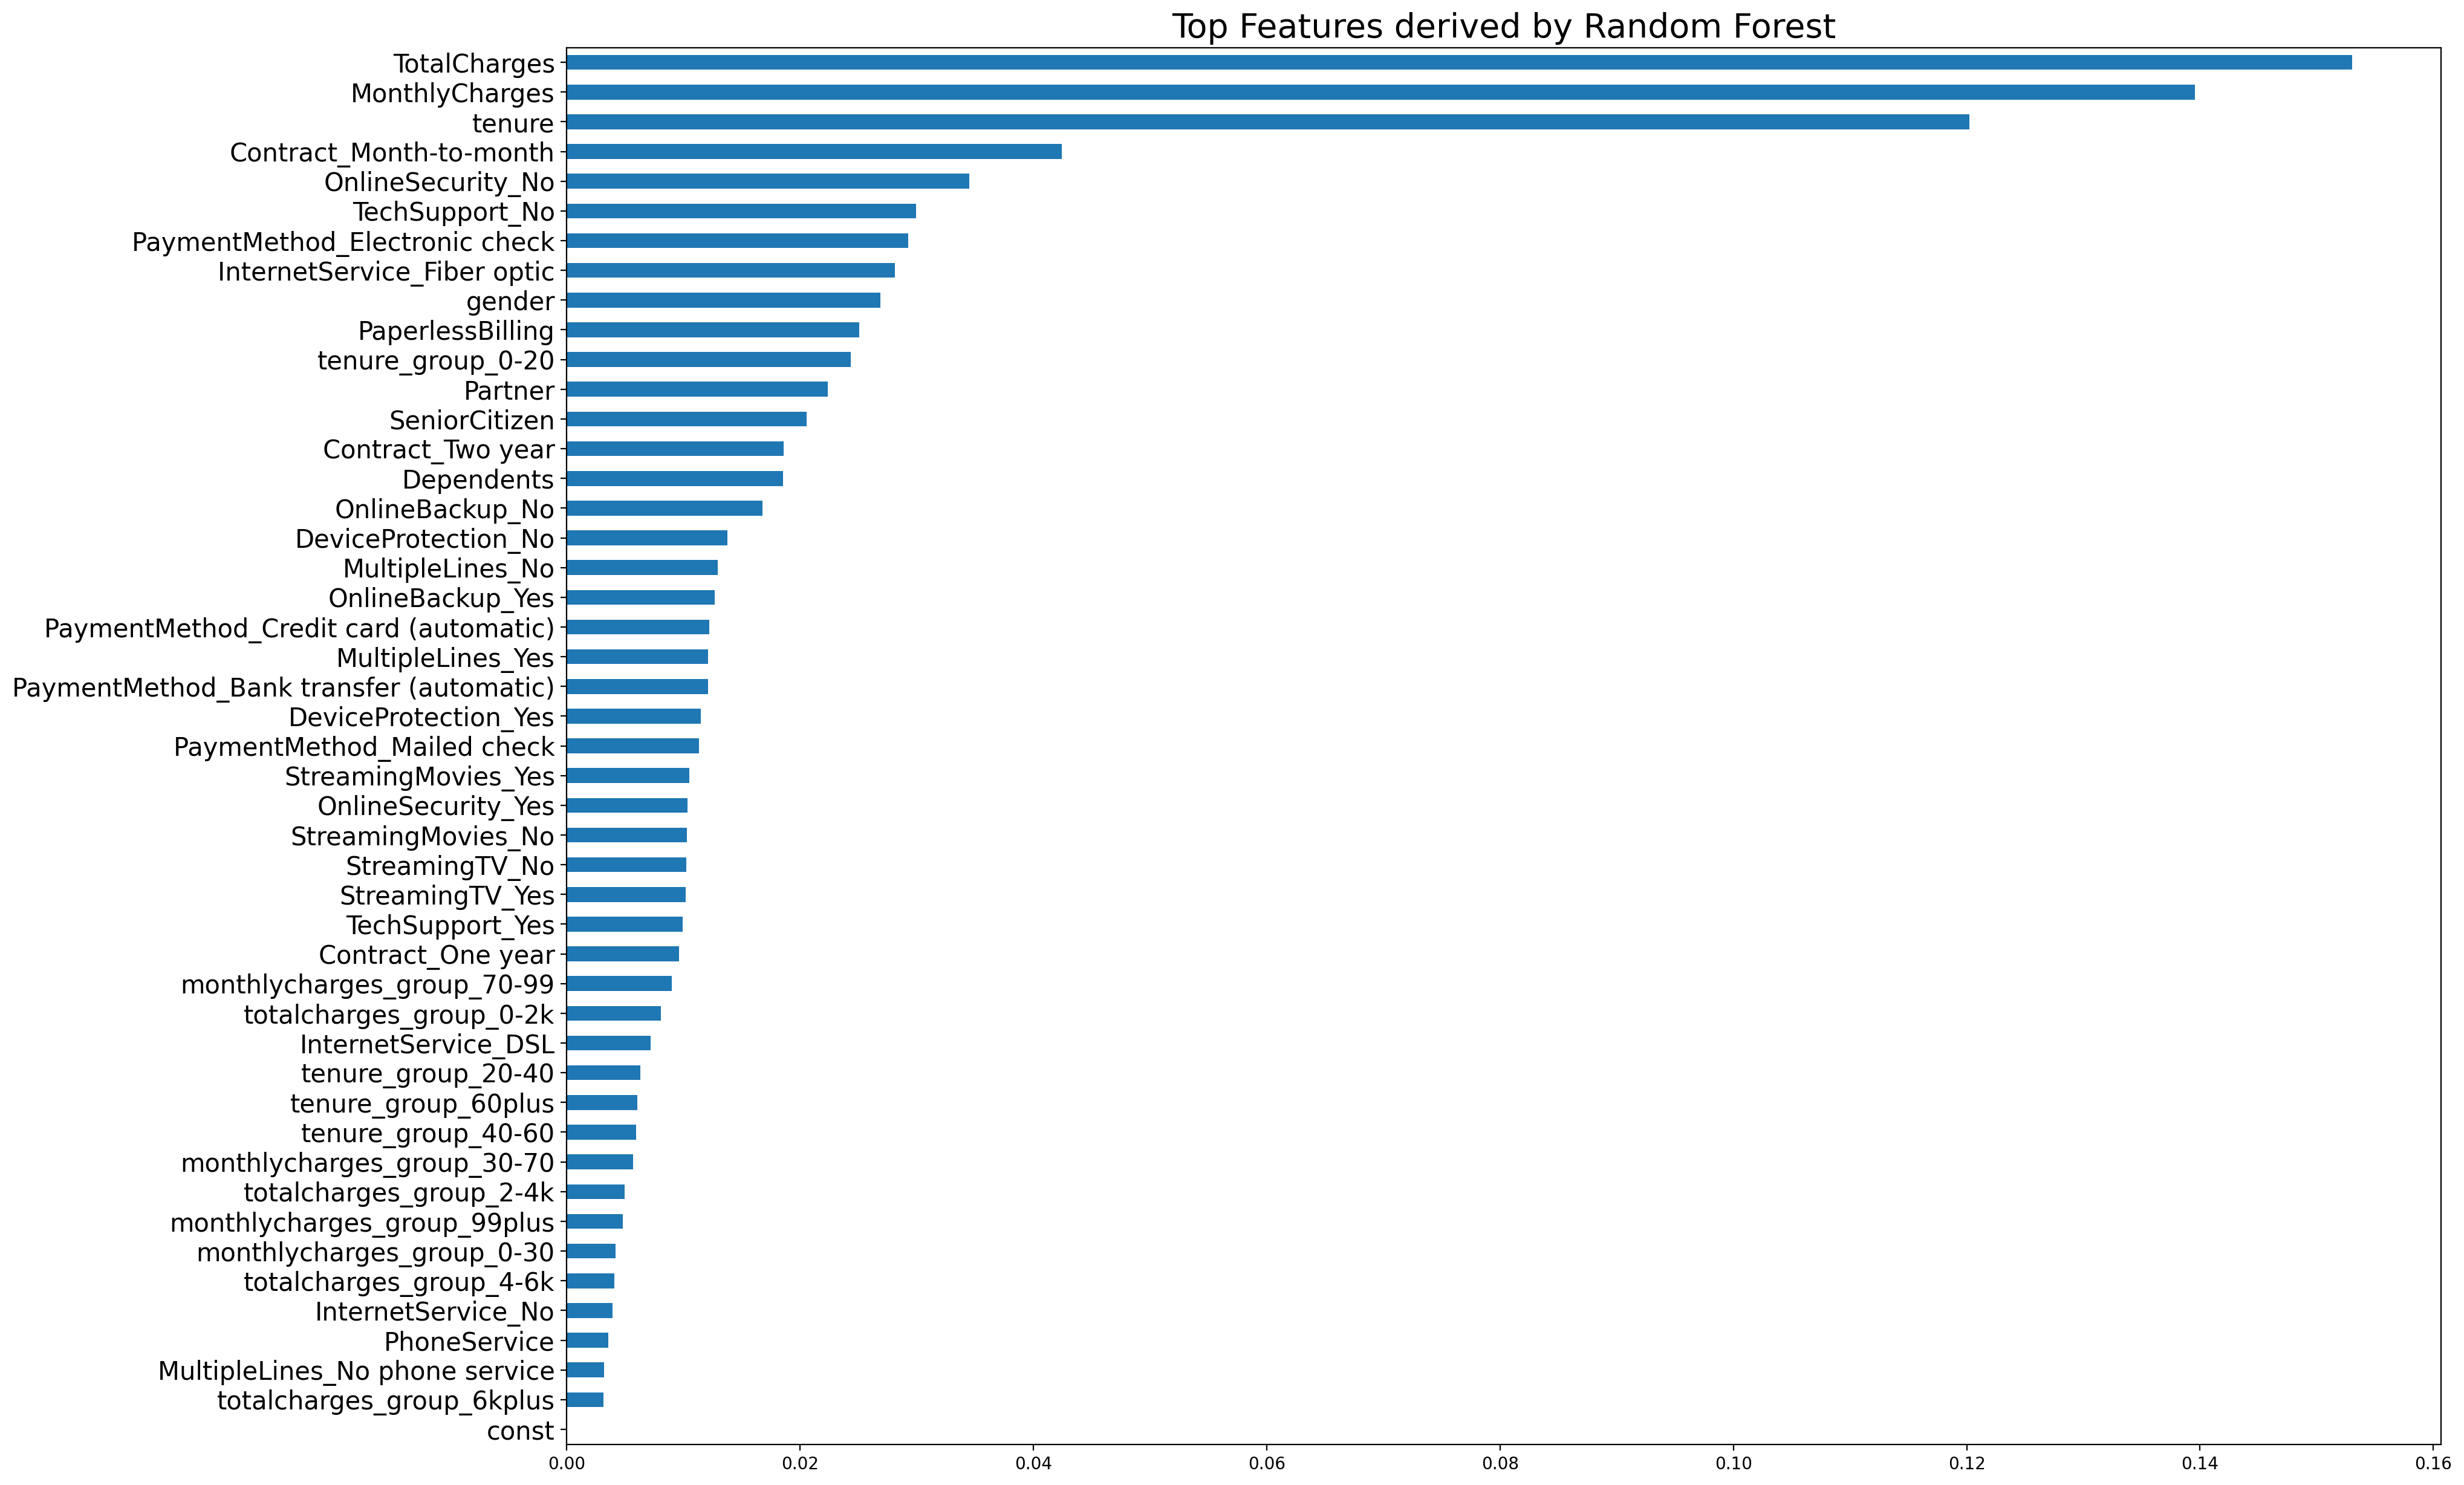

In [43]:
## to look for top features using Random forest
# Create decision classifier object

rfc = RandomForestClassifier(random_state=0, n_estimators=100)
model = rfc.fit(X, y)

# Plot the top features based on its importance
(
    pd.Series(model.feature_importances_, index=X.columns).nlargest(47).plot(kind='barh', figsize=[20, 15]).invert_yaxis()
)
plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=71)

In [45]:
def model_report(model_name, model):
  print("\n Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data")
  model.fit(X_train, y_train)
  optimal_th = 0.5

  for i in range(0, 3):
    score_list = []
    print("\nLooping decimal place", i+1)
    th_list = [
        np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11),
        np.linspace(optimal_th-0.1, optimal_th+0.1, 21),
        np.linspace(optimal_th-0.01, optimal_th+0.01, 21)
    ]

    for th in th_list[i]:
      y_pred = (model.predict_proba(X_test)[:, 1]>=th)
      f1scor = f1_score(y_test, y_pred)
      score_list.append(f1scor)
      print("{:.3f}->{:.4f}".format(th, f1scor), end=", ")

    optimal_th = float(th_list[i][score_list.index(max(score_list))])

  print("optimal f1 score = {:.4f}".format(max(score_list)))
  print("optimal threshold = {:.3f}".format(optimal_th))

  print(model_name, 'accuracy score is')
  print("Training: {:2f}%".format(100*model.score(X_train, y_train)))
  print("Test set: {:2f}%".format(100*model.score(X_test, y_test)))


  y_pred = (model.predict_proba(X_test)[:, 1] >= 0.25)
  print("\nAdjust threshold to 0.25: ")
  print("precision: {:4f}, recall: {:4f}, F1_score: {:4f}".format(
      precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
  ))
  print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

  y_pred = (model.predict_proba(X_test)[:, 1] >= 0.50)
  print("\nAdjust threshold to 0.50: ")
  print("precision: {:4f}, recall: {:4f}, F1_score: {:4f}".format(
      precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
  ))
  print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))


  y_pred = (model.predict_proba(X_test)[:, 1] >= 0.75)
  print("\nAdjust threshold to 0.75: ")
  print("precision: {:4f}, recall: {:4f}, F1_score: {:4f}".format(
      precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
  ))
  print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))


  y_pred = (model.predict_proba(X_test)[:, 1] >= optimal_th)
  print("\nAdjust threshold {:.3f}:".format(optimal_th))
  print("precision: {:4f}, recall: {:4f}, F1_score: {:4f}".format(
      precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
  ))
  print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))


  global model_f1, model_auc, model_ll, model_roc_auc
  model_f1 = f1_score(y_test, y_pred)

  y_pred = model.predict_proba(X_test)
  model_ll = log_loss(y_test, y_pred)
  print(model_name, "log-loss: {:.4f}".format(model_ll))
  y_pred = model.predict(X_test)
  model_roc_auc = roc_auc_score(y_test, y_pred)
  print(model_name, "roc_auc_score: {:.4f}".format(model_ll))
  y_pred = model.predict_proba(X_test)[:, 1]
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  model_auc = auc(fpr, tpr)
  print(model_name, "auc: {:.4f}".format(model_ll))

  # plot the ROC curve
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % model_auc)
  plt.plot([0, 1], [0, 1], 'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('Receiver Operating Characterstic')
  plt.legend(loc = "lower right")
  plt.show()
  return

# initialize lists t collect the result to plot later
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []





 ************* GaussianNB ***********

 Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5794, 0.100->0.6181, 0.200->0.6213, 0.300->0.6228, 0.400->0.6265, 0.500->0.6269, 0.600->0.6263, 0.700->0.6264, 0.800->0.6280, 0.900->0.6274, 1.000->0.5719, 
Looping decimal place 2
0.700->0.6264, 0.710->0.6242, 0.720->0.6242, 0.730->0.6242, 0.740->0.6249, 0.750->0.6255, 0.760->0.6268, 0.770->0.6275, 0.780->0.6282, 0.790->0.6282, 0.800->0.6280, 0.810->0.6287, 0.820->0.6272, 0.830->0.6271, 0.840->0.6291, 0.850->0.6290, 0.860->0.6282, 0.870->0.6267, 0.880->0.6267, 0.890->0.6274, 0.900->0.6274, 
Looping decimal place 3
0.830->0.6271, 0.831->0.6271, 0.832->0.6271, 0.833->0.6278, 0.834->0.6278, 0.835->0.6278, 0.836->0.6285, 0.837->0.6285, 0.838->0.6285, 0.839->0.6285, 0.840->0.6291, 0.841->0.6291, 0.842->0.6291, 0.843->0.6291, 0.844->0.6291, 0.845->0.6291, 0.846->0.6298, 0.847->0.6298, 0.848->0.6305, 0.849->0.6305, 0.850->0.6290, 

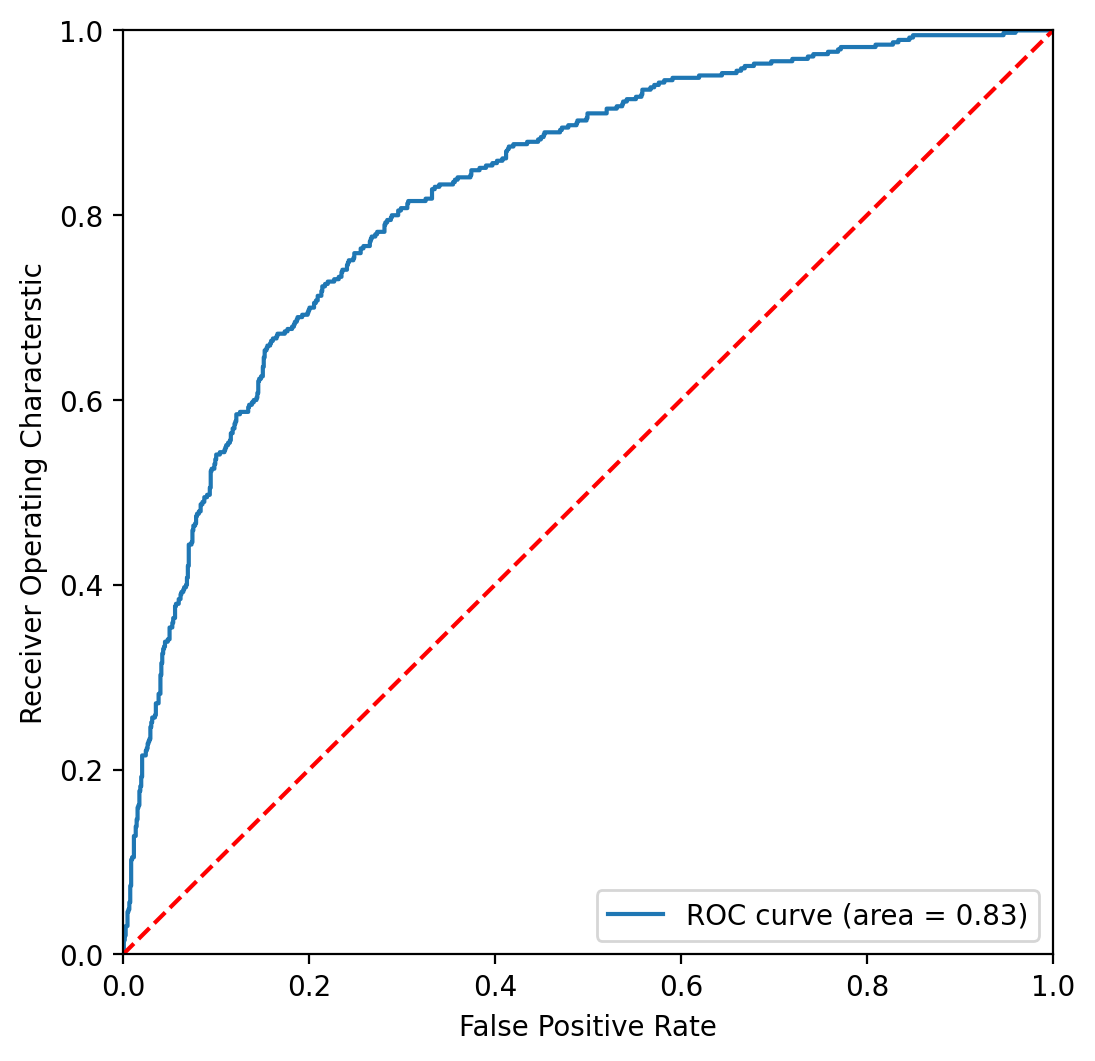


 ************* BernoulliNB ***********

 Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5453, 0.100->0.6198, 0.200->0.6242, 0.300->0.6254, 0.400->0.6283, 0.500->0.6330, 0.600->0.6332, 0.700->0.6373, 0.800->0.6403, 0.900->0.6338, 1.000->0.2457, 
Looping decimal place 2
0.700->0.6373, 0.710->0.6395, 0.720->0.6395, 0.730->0.6394, 0.740->0.6408, 0.750->0.6407, 0.760->0.6429, 0.770->0.6436, 0.780->0.6396, 0.790->0.6411, 0.800->0.6403, 0.810->0.6417, 0.820->0.6415, 0.830->0.6423, 0.840->0.6390, 0.850->0.6389, 0.860->0.6369, 0.870->0.6344, 0.880->0.6382, 0.890->0.6389, 0.900->0.6338, 
Looping decimal place 3
0.760->0.6429, 0.761->0.6429, 0.762->0.6429, 0.763->0.6429, 0.764->0.6429, 0.765->0.6429, 0.766->0.6436, 0.767->0.6436, 0.768->0.6436, 0.769->0.6436, 0.770->0.6436, 0.771->0.6436, 0.772->0.6436, 0.773->0.6412, 0.774->0.6412, 0.775->0.6412, 0.776->0.6396, 0.777->0.6396, 0.778->0.6396, 0.779->0.6396, 0.780->0.6396,

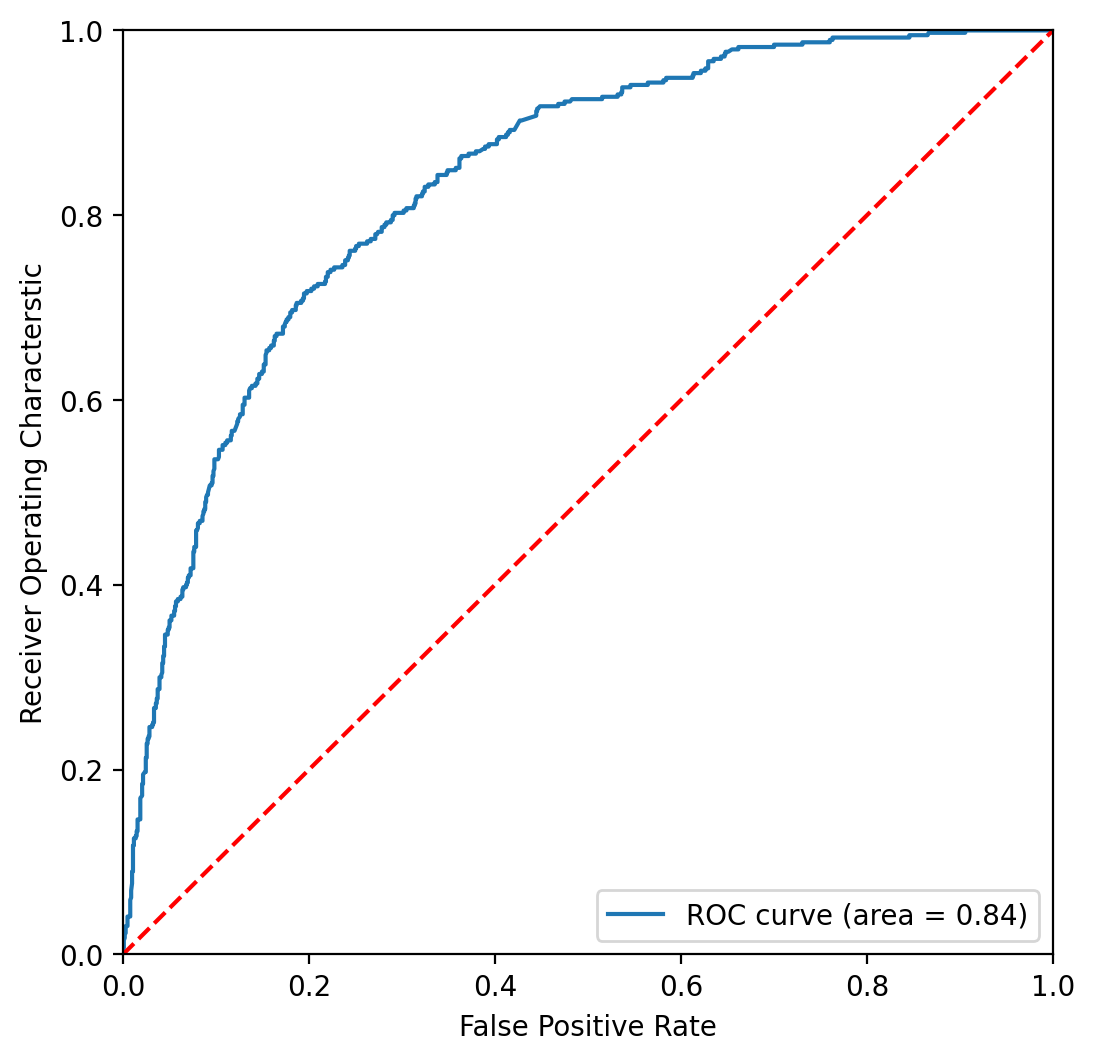

In [46]:
print("\n ************* GaussianNB ***********")
time1 = time.time()
gnb = GaussianNB()
model_report("GaussianNB", gnb)

model_list.append("GaussianNB")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

print("\n ************* BernoulliNB ***********")
time1 = time.time()
bnb = BernoulliNB()
model_report("BernoulliNB", bnb)

model_list.append("BernoulliNB")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

***************** Logistic Regression ********************

Search for optimal hyperparameter C in Logistic Regression 
0.3684, 0.3897, 0.4073, 0.4208, 0.4332, 0.4450, 0.4528, 0.4594, 0.4706, 0.4789, 0.4844, 0.4890, 0.4932, 0.4985, 0.5034, 0.5117, 0.5151, 0.5218, 0.5265, 0.5347, 0.5371, 0.5373, 0.5395, 0.5414, 0.5451, 0.5447, 0.5499, 0.5510, 0.5566, 0.5615, 0.5637, 0.5638, 0.5653, 0.5673, 0.5691, 0.5706, 0.5711, 0.5730, 0.5739, 0.5742, 0.5740, 0.5744, 0.5774, 0.5779, 0.5785, 0.5789, 0.5784, 0.5791, 0.5798, 0.5794, 0.5801, 0.5813, 0.5820, 0.5802, 0.5792, 0.5785, 0.5799, 0.5805, 0.5806, 0.5820, 0.5812, 0.5815, 0.5817, 0.5825, 0.5812, 0.5831, 0.5831, 0.5828, 0.5809, 0.5821, 0.5828, 0.5821, 0.5839, 0.5848, 0.5850, 0.5855, 0.5856, 0.5851, 0.5851, 0.5853, 0.5867, 0.5862, 0.5857, 0.5861, 0.5866, 0.5868, 0.5876, 0.5876, 0.5868, 0.5868, 0.5863, 0.5865, 0.5855, 0.5859, 0.5851, 0.5844, 0.5839, 0.5841, 0.5832, 0.5837, 0.5840, 0.5827, 0.5834, 0.5837, 0.5840, 0.5834, 0.5834, 0.5829, 0.5840, 0.5829, 

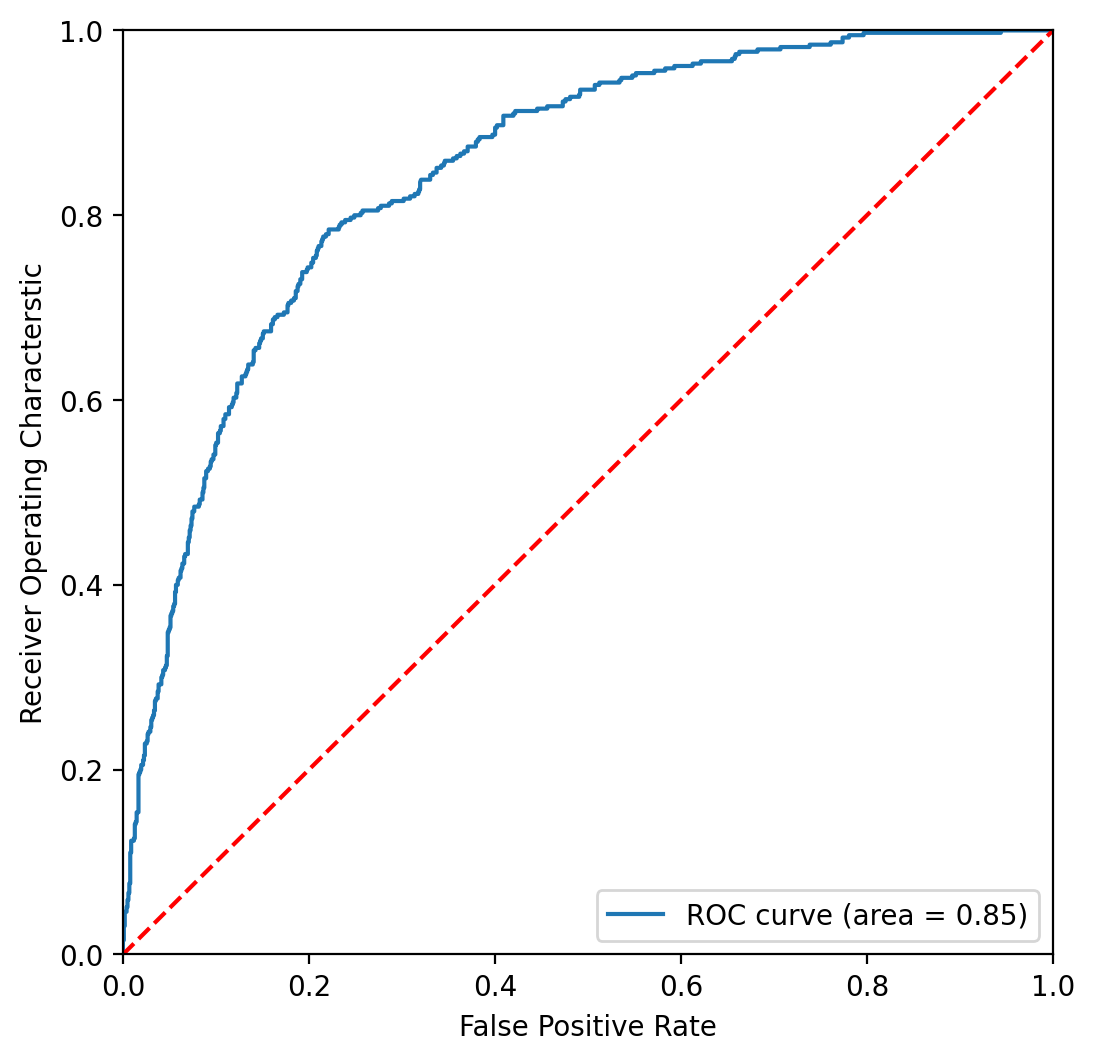

In [47]:
print("***************** Logistic Regression ********************")
print("\nSearch for optimal hyperparameter C in Logistic Regression, vary C from 0.001 to 1000")
kf = KFold(n_splits=5, random_state=21, shuffle=True)
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
  logit = LogisticRegression(C= c)
  cvs = (cross_val_score(logit, X_train, y_train, cv = kf, scoring = 'f1')).mean()
  score_list.append(cvs)
  print("{:.4f}".format(cvs), end=", ")

print("Optimal cv F1 score = {:.4f}".format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print("Optimal value of C = {:.3f}".format(optimal_c))

time1 = time.time()
logit = LogisticRegression(C = optimal_c)
model_report("LogisticRegression", logit)

model_list.append("LogisticRegression")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

***************** KNN ********************

Search for optimal hyperparameter k in KNN, vary C from 1 to 20
0.4682, 0.3894, 0.5215, 0.4656, 0.5311, 0.4917, 0.5491, 0.5153, 0.5631, 0.5269, 0.5562, 0.5371, 0.5636, 0.5426, 0.5672, 0.5492, 0.5764, 0.5576, 0.5761, 0.5576, Optimal cv F1 score = 0.5764
Optimal value of k =  17

 Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5100, 0.100->0.5538, 0.200->0.6069, 0.300->0.6213, 0.400->0.6236, 0.500->0.6103, 0.600->0.4650, 0.700->0.4052, 0.800->0.2173, 0.900->0.0500, 1.000->0.0203, 
Looping decimal place 2
0.300->0.6213, 0.310->0.6213, 0.320->0.6213, 0.330->0.6213, 0.340->0.6213, 0.350->0.6213, 0.360->0.6236, 0.370->0.6236, 0.380->0.6236, 0.390->0.6236, 0.400->0.6236, 0.410->0.6236, 0.420->0.6193, 0.430->0.6193, 0.440->0.6193, 0.450->0.6193, 0.460->0.6193, 0.470->0.6193, 0.480->0.6103, 0.490->0.6103, 0.500->0.6103, 
Looping decimal place 3
0.350->0.6213, 0.351->0.6213, 0.

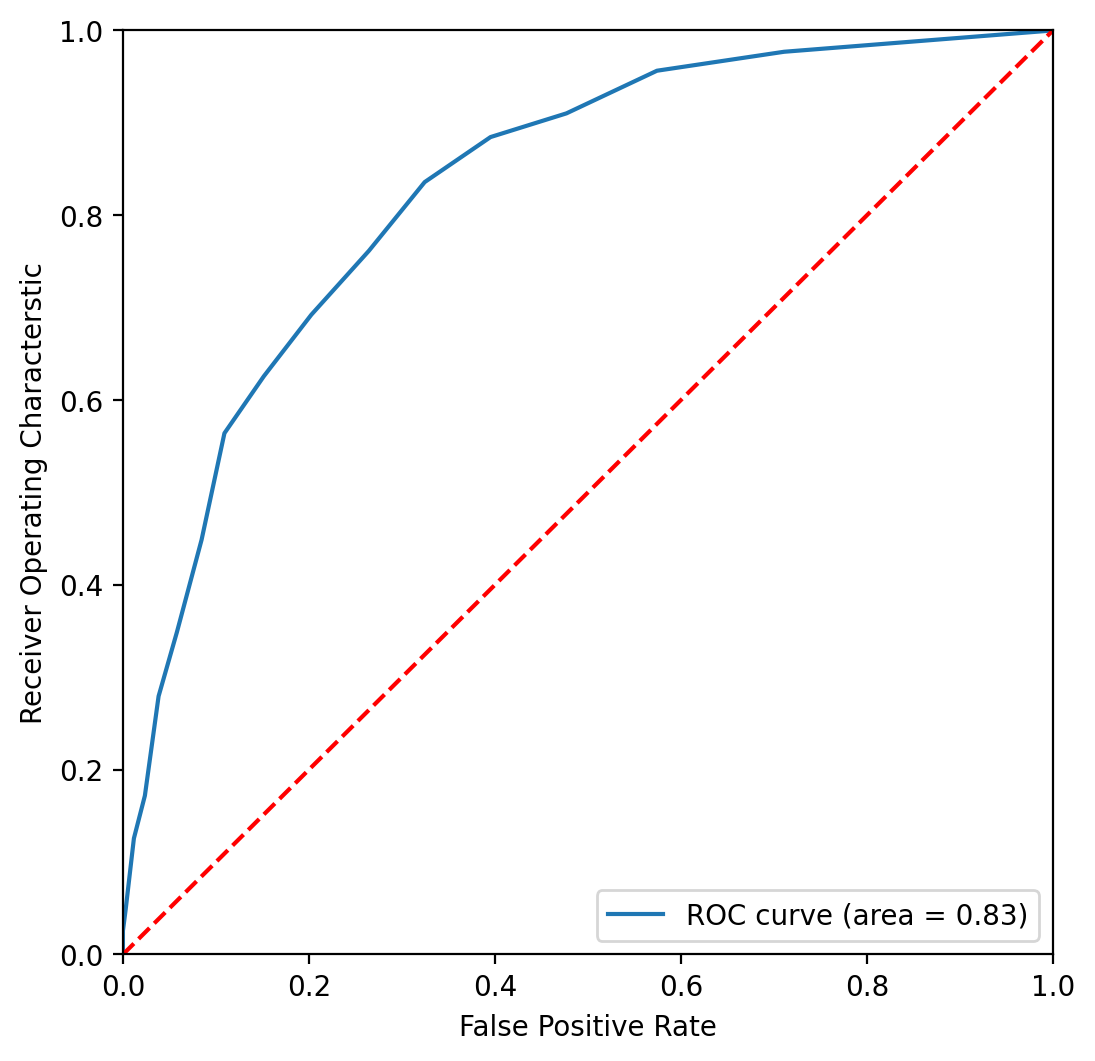


Compare with KNN Classification_report (same as default threshold 0.50)
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1017
           1       0.66      0.56      0.61       390

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.79      0.80      0.79      1407



In [48]:
print("***************** KNN ********************")
print("\nSearch for optimal hyperparameter k in KNN, vary C from 1 to 20")
kf = KFold(n_splits=5, random_state=21, shuffle=True)
k_scores = []
for k in range(1, 21):
  knn = KNeighborsClassifier(n_neighbors=k)
  cvs = (cross_val_score(knn, X_train, y_train, cv = kf, scoring = 'f1')).mean()
  k_scores.append(cvs)
  print("{:.4f}".format(cvs), end=", ")

print("Optimal cv F1 score = {:.4f}".format(max(k_scores)))
optimal_k = k_scores.index(max(k_scores)) + 1
print("Optimal value of k = ", optimal_k)

time1 = time.time()
knn = KNeighborsClassifier(n_neighbors=optimal_k)
model_report("KNeighborsClassifier", knn)

print("\nCompare with KNN Classification_report (same as default threshold 0.50)")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

model_list.append("KNN")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

***************** DecisionTreeClassifier ********************

Search for optimal max_depth  in DecisionTreeClassifier, vary  from 2 to 10
0.5787, 0.5062, 0.5624, 0.5609, 0.5642, 0.5648, 0.5297, 0.5314, 0.5360, Optimal cv F1 score = 0.5787
Optimal value of k =  2

 Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4341, 0.100->0.5480, 0.200->0.5811, 0.300->0.5911, 0.400->0.5911, 0.500->0.5911, 0.600->0.0000, 0.700->0.0000, 0.800->0.0000, 0.900->0.0000, 1.000->0.0000, 
Looping decimal place 2
0.200->0.5811, 0.210->0.5811, 0.220->0.5811, 0.230->0.5811, 0.240->0.5811, 0.250->0.5811, 0.260->0.5811, 0.270->0.5811, 0.280->0.5811, 0.290->0.5911, 0.300->0.5911, 0.310->0.5911, 0.320->0.5911, 0.330->0.5911, 0.340->0.5911, 0.350->0.5911, 0.360->0.5911, 0.370->0.5911, 0.380->0.5911, 0.390->0.5911, 0.400->0.5911, 
Looping decimal place 3
0.280->0.5811, 0.281->0.5811, 0.282->0.5811, 0.283->0.5911, 0.284->0.5911, 0.285->0.5911, 

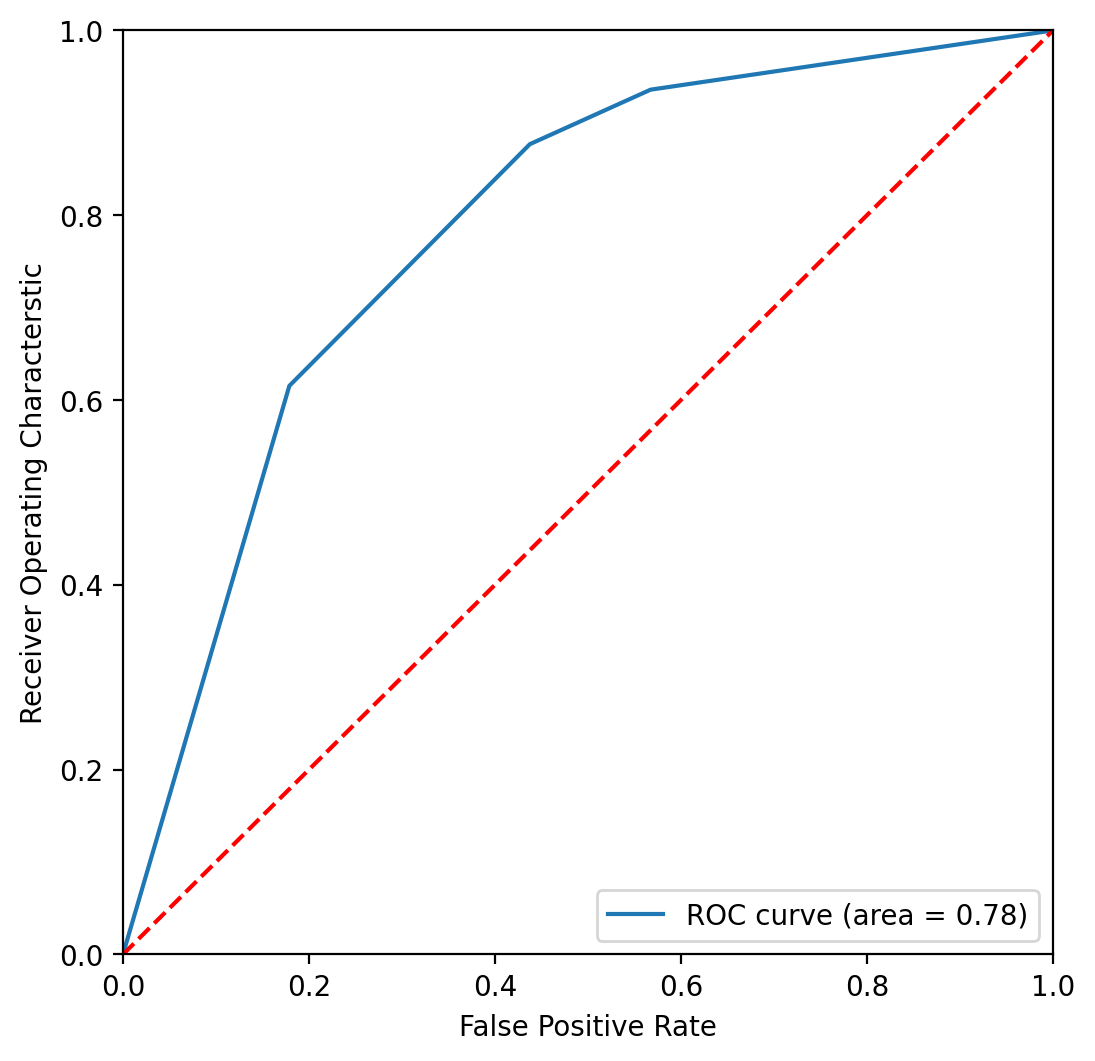

In [50]:
print("***************** DecisionTreeClassifier ********************")
print("\nSearch for optimal max_depth  in DecisionTreeClassifier, vary  from 2 to 10")
kf = KFold(n_splits=5, random_state=21, shuffle=True)
d_scores = []
for d in range(2, 11):
  decisiontree = DecisionTreeClassifier(max_depth=d)
  cvs = (cross_val_score(decisiontree, X_train, y_train, cv = kf, scoring = 'f1')).mean()
  d_scores.append(cvs)
  print("{:.4f}".format(cvs), end=", ")

print("Optimal cv F1 score = {:.4f}".format(max(d_scores)))
optimal_d = d_scores.index(max(d_scores)) + 2
print("Optimal value of k = ", optimal_d)

time1 = time.time()
decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model_report("DecisionTreeClassifier", decisiontree)

# print("\nCompare with KNN Classification_report (same as default threshold 0.50)")
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# print(metrics.classification_report(y_test, y_pred))

model_list.append("DecisionTreeClassifier")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

***************** Random Forest Classifier ********************

Search for optimal n_estimator  in RandomForest, vary  from 100 to 500
50 -> 0.5407, 70 -> 0.5344, 100 -> 0.5451, 150 -> 0.5476, 200 -> 0.5447, Optimal cv F1 score = 0.5476
Optimal value of n_estimators = 150

 Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4707, 0.100->0.5594, 0.200->0.6164, 0.300->0.6254, 0.400->0.6184, 0.500->0.5471, 0.600->0.4823, 0.700->0.3647, 0.800->0.2338, 0.900->0.1371, 1.000->0.0153, 
Looping decimal place 2
0.200->0.6164, 0.210->0.6169, 0.220->0.6145, 0.230->0.6223, 0.240->0.6274, 0.250->0.6277, 0.260->0.6327, 0.270->0.6386, 0.280->0.6300, 0.290->0.6276, 0.300->0.6254, 0.310->0.6251, 0.320->0.6309, 0.330->0.6336, 0.340->0.6270, 0.350->0.6320, 0.360->0.6265, 0.370->0.6267, 0.380->0.6187, 0.390->0.6142, 0.400->0.6184, 
Looping decimal place 3
0.260->0.6327, 0.261->0.6327, 0.262->0.6327, 0.263->0.6327, 0.264->0.6327, 0.265

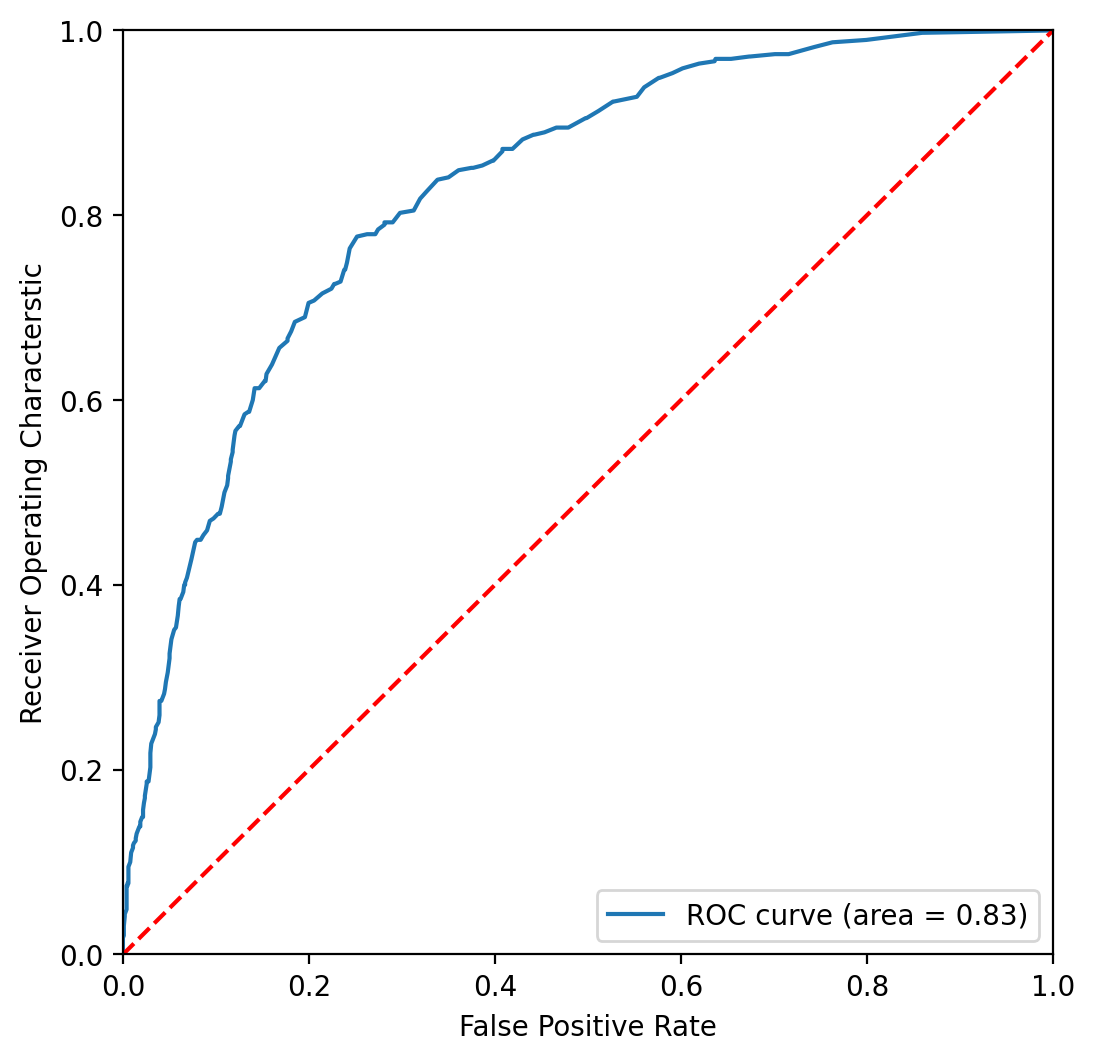

In [52]:
print("***************** Random Forest Classifier ********************")
print("\nSearch for optimal n_estimator  in RandomForest, vary  from 100 to 500")
kf = KFold(n_splits=5, random_state=21, shuffle=True)
score_list = []
n_list = []
for n in [50, 70, 100, 150, 200]:
  randomforest = RandomForestClassifier(n_estimators=n)
  cvs = (cross_val_score(randomforest, X_train, y_train, cv = kf, scoring = 'f1')).mean()
  score_list.append(cvs)
  n_list.append(n)
  print("{:.0f} -> {:.4f}".format(n, cvs), end=", ")

print("Optimal cv F1 score = {:.4f}".format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print("Optimal value of n_estimators = {:.0f}".format(optimal_n))

time1 = time.time()
randomforest = RandomForestClassifier(n_estimators=optimal_n)
model_report("RandomForestClassifier", randomforest)


model_list.append("RandomForestClassifier")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

*************** LinearSVC ********************
Linear SVC accuracy is :
Training: 80.53%
Test: 79.74%
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1017
           1       0.69      0.49      0.57       390

    accuracy                           0.80      1407
   macro avg       0.76      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

LinearSVC confusion matrix: 
 [[932  85]
 [200 190]]
LinearSVC log-loss: 7.3010
LinearSVC roc_auc_score: 0.7018
LinearSVC AUC: 0.7018


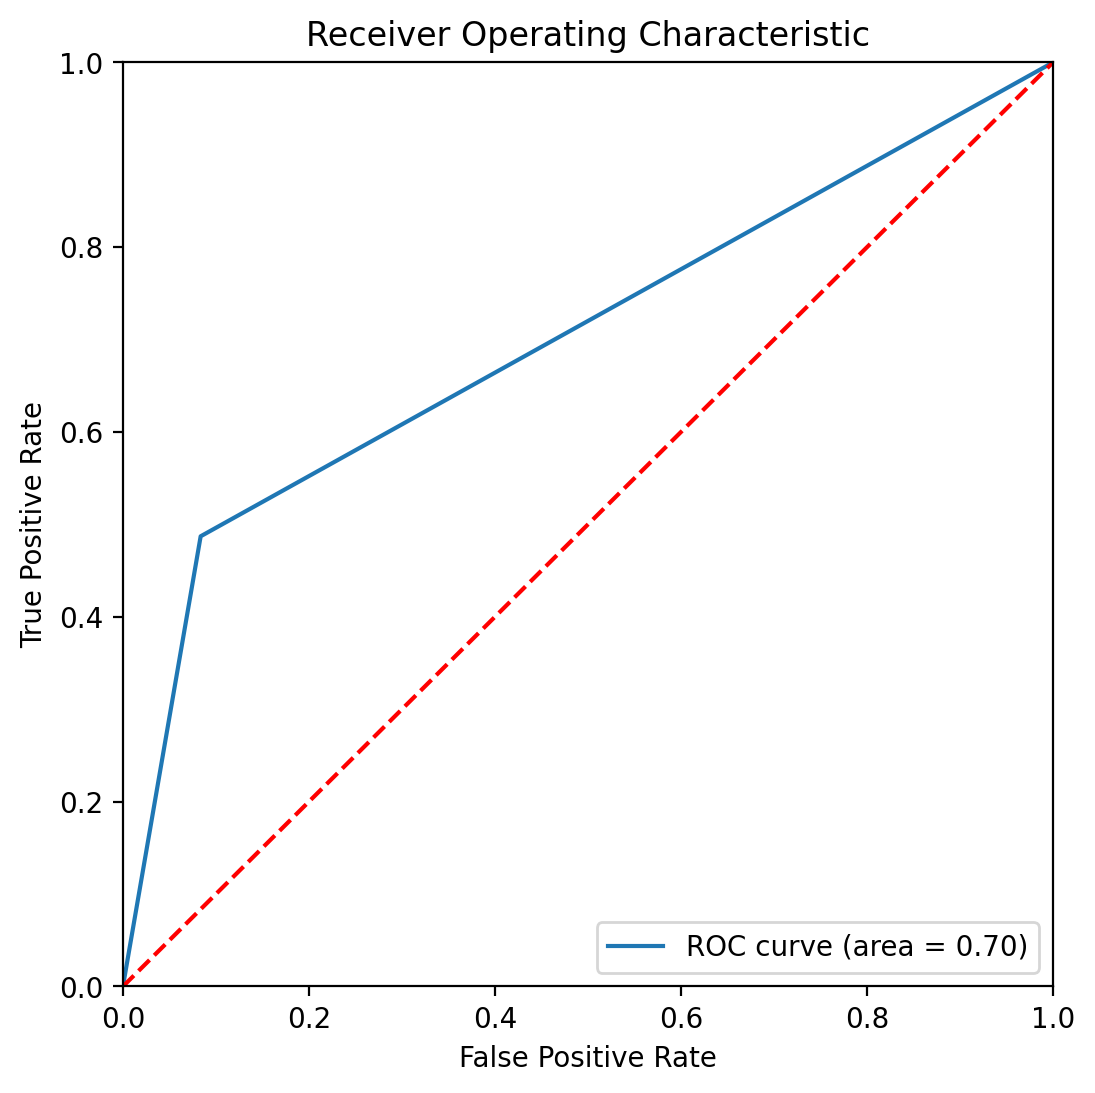

In [54]:
print("*************** LinearSVC ********************")
time1 = time.time()
linearsvc = LinearSVC()
# model_report("linearsvc", linearsvc) # this model has no attribute class predict_proba
linearsvc.fit(X_train, y_train)
print("Linear SVC accuracy is :")
print("Training: {:.2f}%".format(100*linearsvc.score(X_train, y_train))) # scores uses accuracy
print("Test: {:.2f}%".format(100*linearsvc.score(X_test, y_test))) # should use cross validation

y_pred = linearsvc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("LinearSVC confusion matrix: \n", confusion_matrix(y_test, y_pred))

model_f1 = f1_score(y_test, y_pred)
model_ll = log_loss(y_test, y_pred)
print("LinearSVC log-loss: {:.4f}".format(model_ll))
model_roc_auc = roc_auc_score(y_test, y_pred)
print("LinearSVC roc_auc_score: {:.4f}".format(model_roc_auc))
fpr, tpr, threshold = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print("LinearSVC AUC: {:.4f}".format(model_auc))


# plot the ROC curve
plt.figure(figsize = [6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('roc_auc_score')
plt.show()


model_list.append('LinearSVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

**************** SVC *****************

 Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4341, 0.100->0.4371, 0.200->0.6420, 0.300->0.6175, 0.400->0.5787, 0.500->0.5434, 0.600->0.4757, 0.700->0.3752, 0.800->0.1982, 0.900->0.0203, 1.000->0.0000, 
Looping decimal place 2
0.100->0.4371, 0.110->0.4399, 0.120->0.4461, 0.130->0.4660, 0.140->0.5052, 0.150->0.6054, 0.160->0.6285, 0.170->0.6448, 0.180->0.6462, 0.190->0.6449, 0.200->0.6420, 0.210->0.6367, 0.220->0.6346, 0.230->0.6255, 0.240->0.6263, 0.250->0.6291, 0.260->0.6285, 0.270->0.6252, 0.280->0.6213, 0.290->0.6173, 0.300->0.6175, 
Looping decimal place 3
0.170->0.6448, 0.171->0.6454, 0.172->0.6416, 0.173->0.6430, 0.174->0.6429, 0.175->0.6413, 0.176->0.6435, 0.177->0.6471, 0.178->0.6440, 0.179->0.6455, 0.180->0.6462, 0.181->0.6446, 0.182->0.6461, 0.183->0.6468, 0.184->0.6460, 0.185->0.6475, 0.186->0.6482, 0.187->0.6467, 0.188->0.6451, 0.189->0.6450, 0.190->0.6449, 

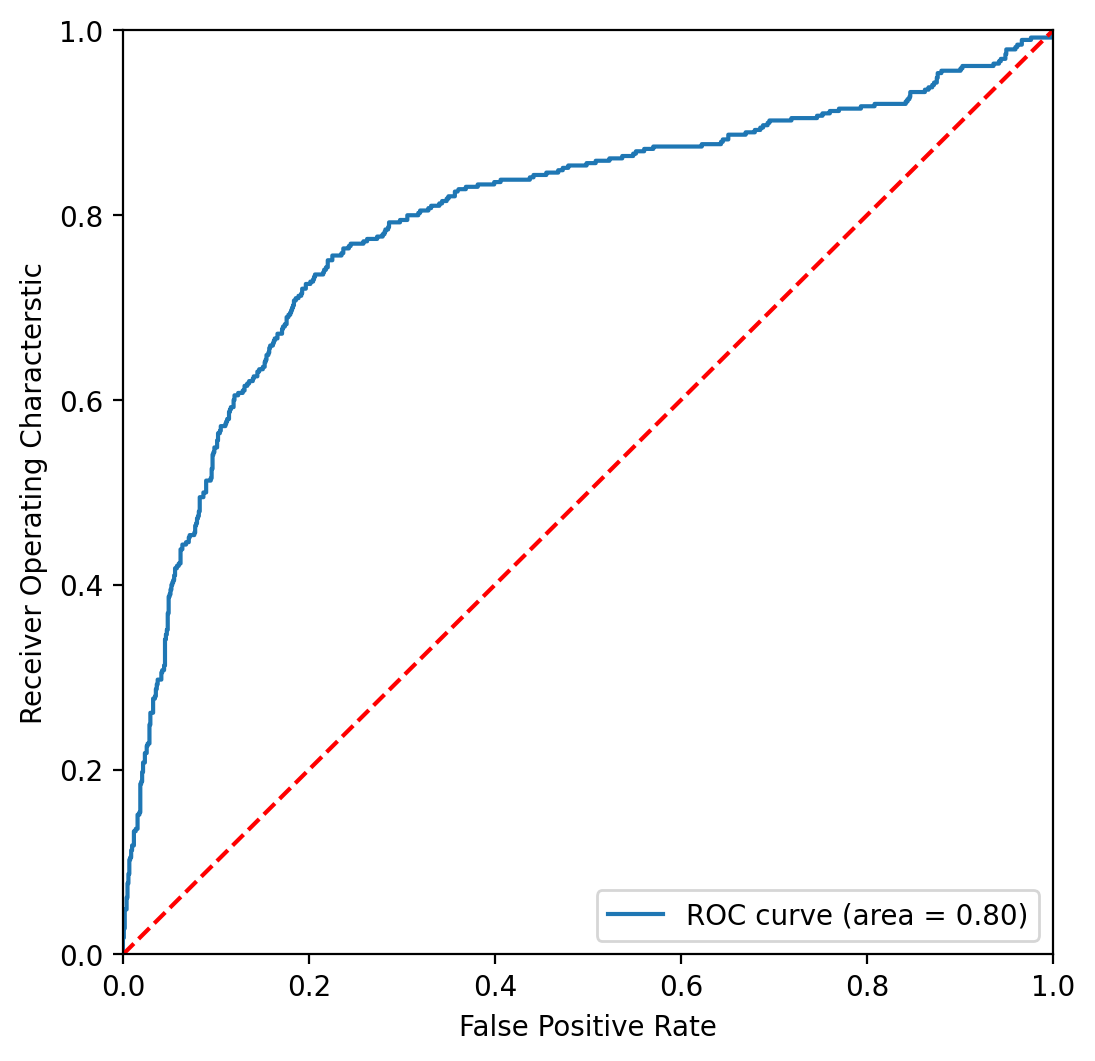

In [55]:
print("**************** SVC *****************")
time1 = time.time()
svc = SVC(gamma="scale", probability=True)
model_report('SVC', svc)

model_list.append("SVC")
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(0)

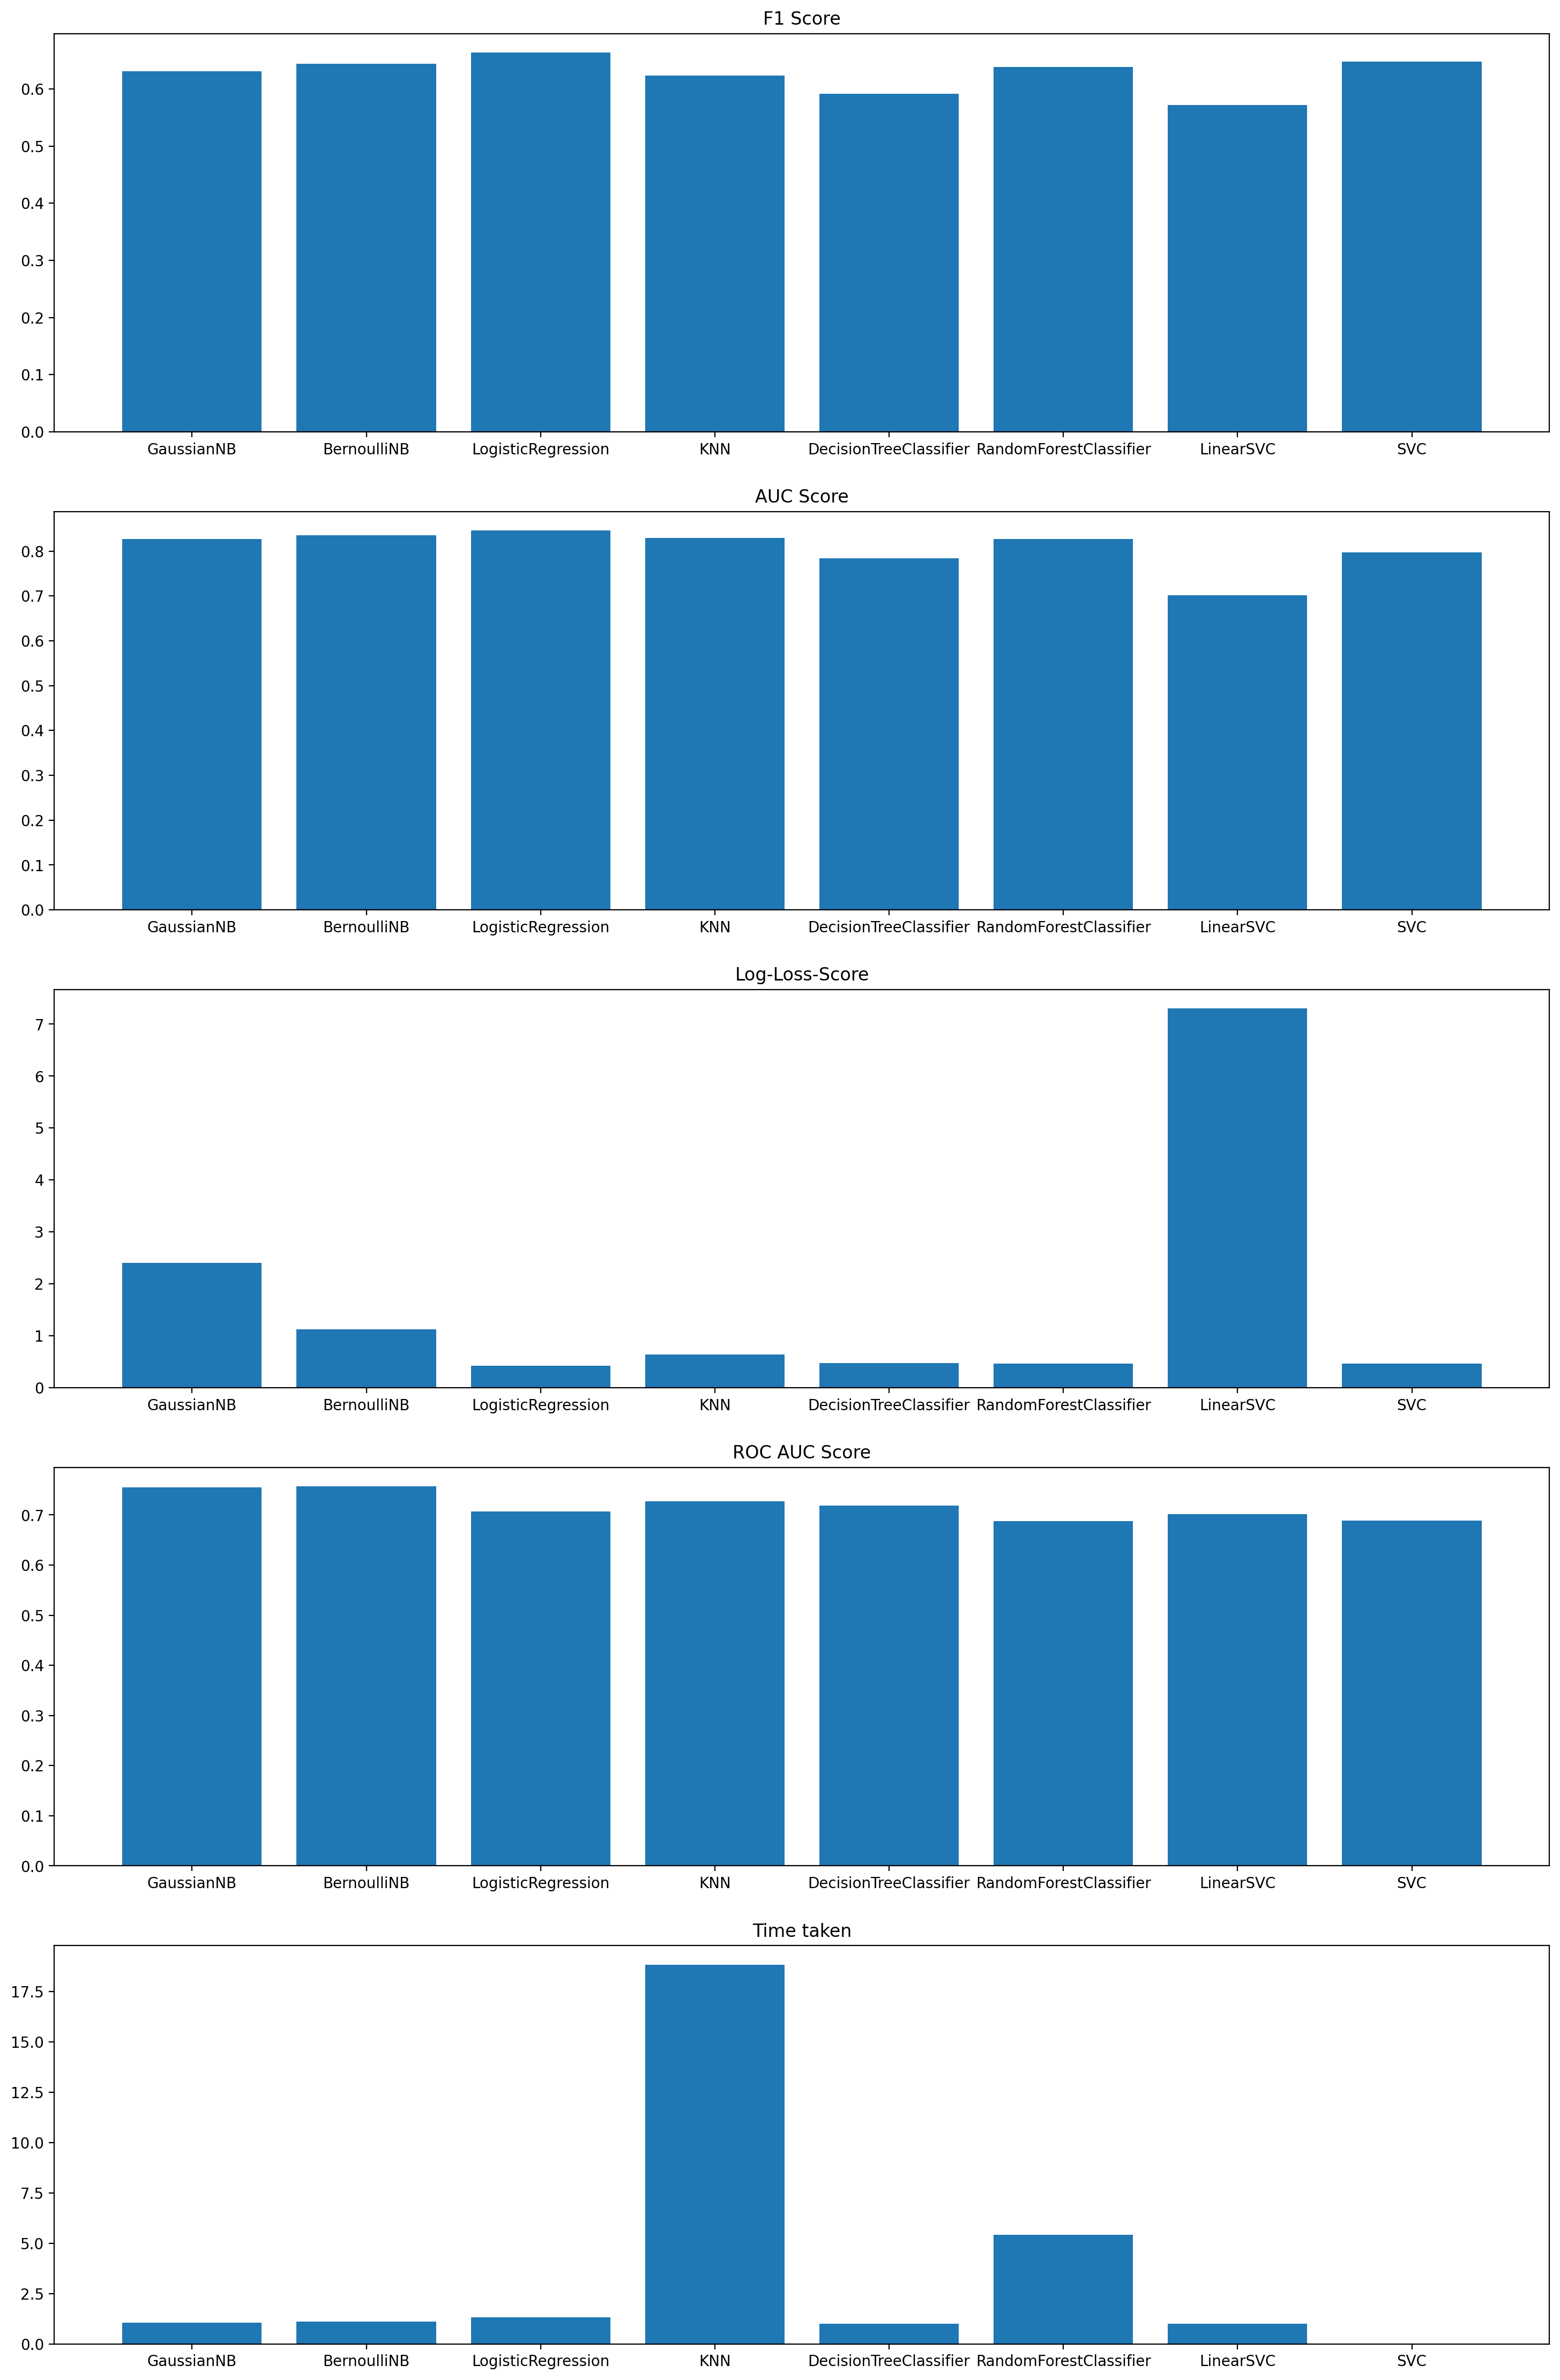

In [58]:
# plot the classification report scores

fig, ax = plt.subplots(5, 1, figsize=(18, 28))
ax[0].bar(model_list, f1_list)
ax[0].set_title("F1 Score")

ax[1].bar(model_list, auc_list)
ax[1].set_title("AUC Score")

ax[2].bar(model_list, ll_list)
ax[2].set_title("Log-Loss-Score")


ax[3].bar(model_list, roc_auc_list)
ax[3].set_title("ROC AUC Score")

ax[4].bar(model_list, time_list)
ax[4].set_title("Time taken")

fig.subplots_adjust(hspace=0.2, wspace=0.2)


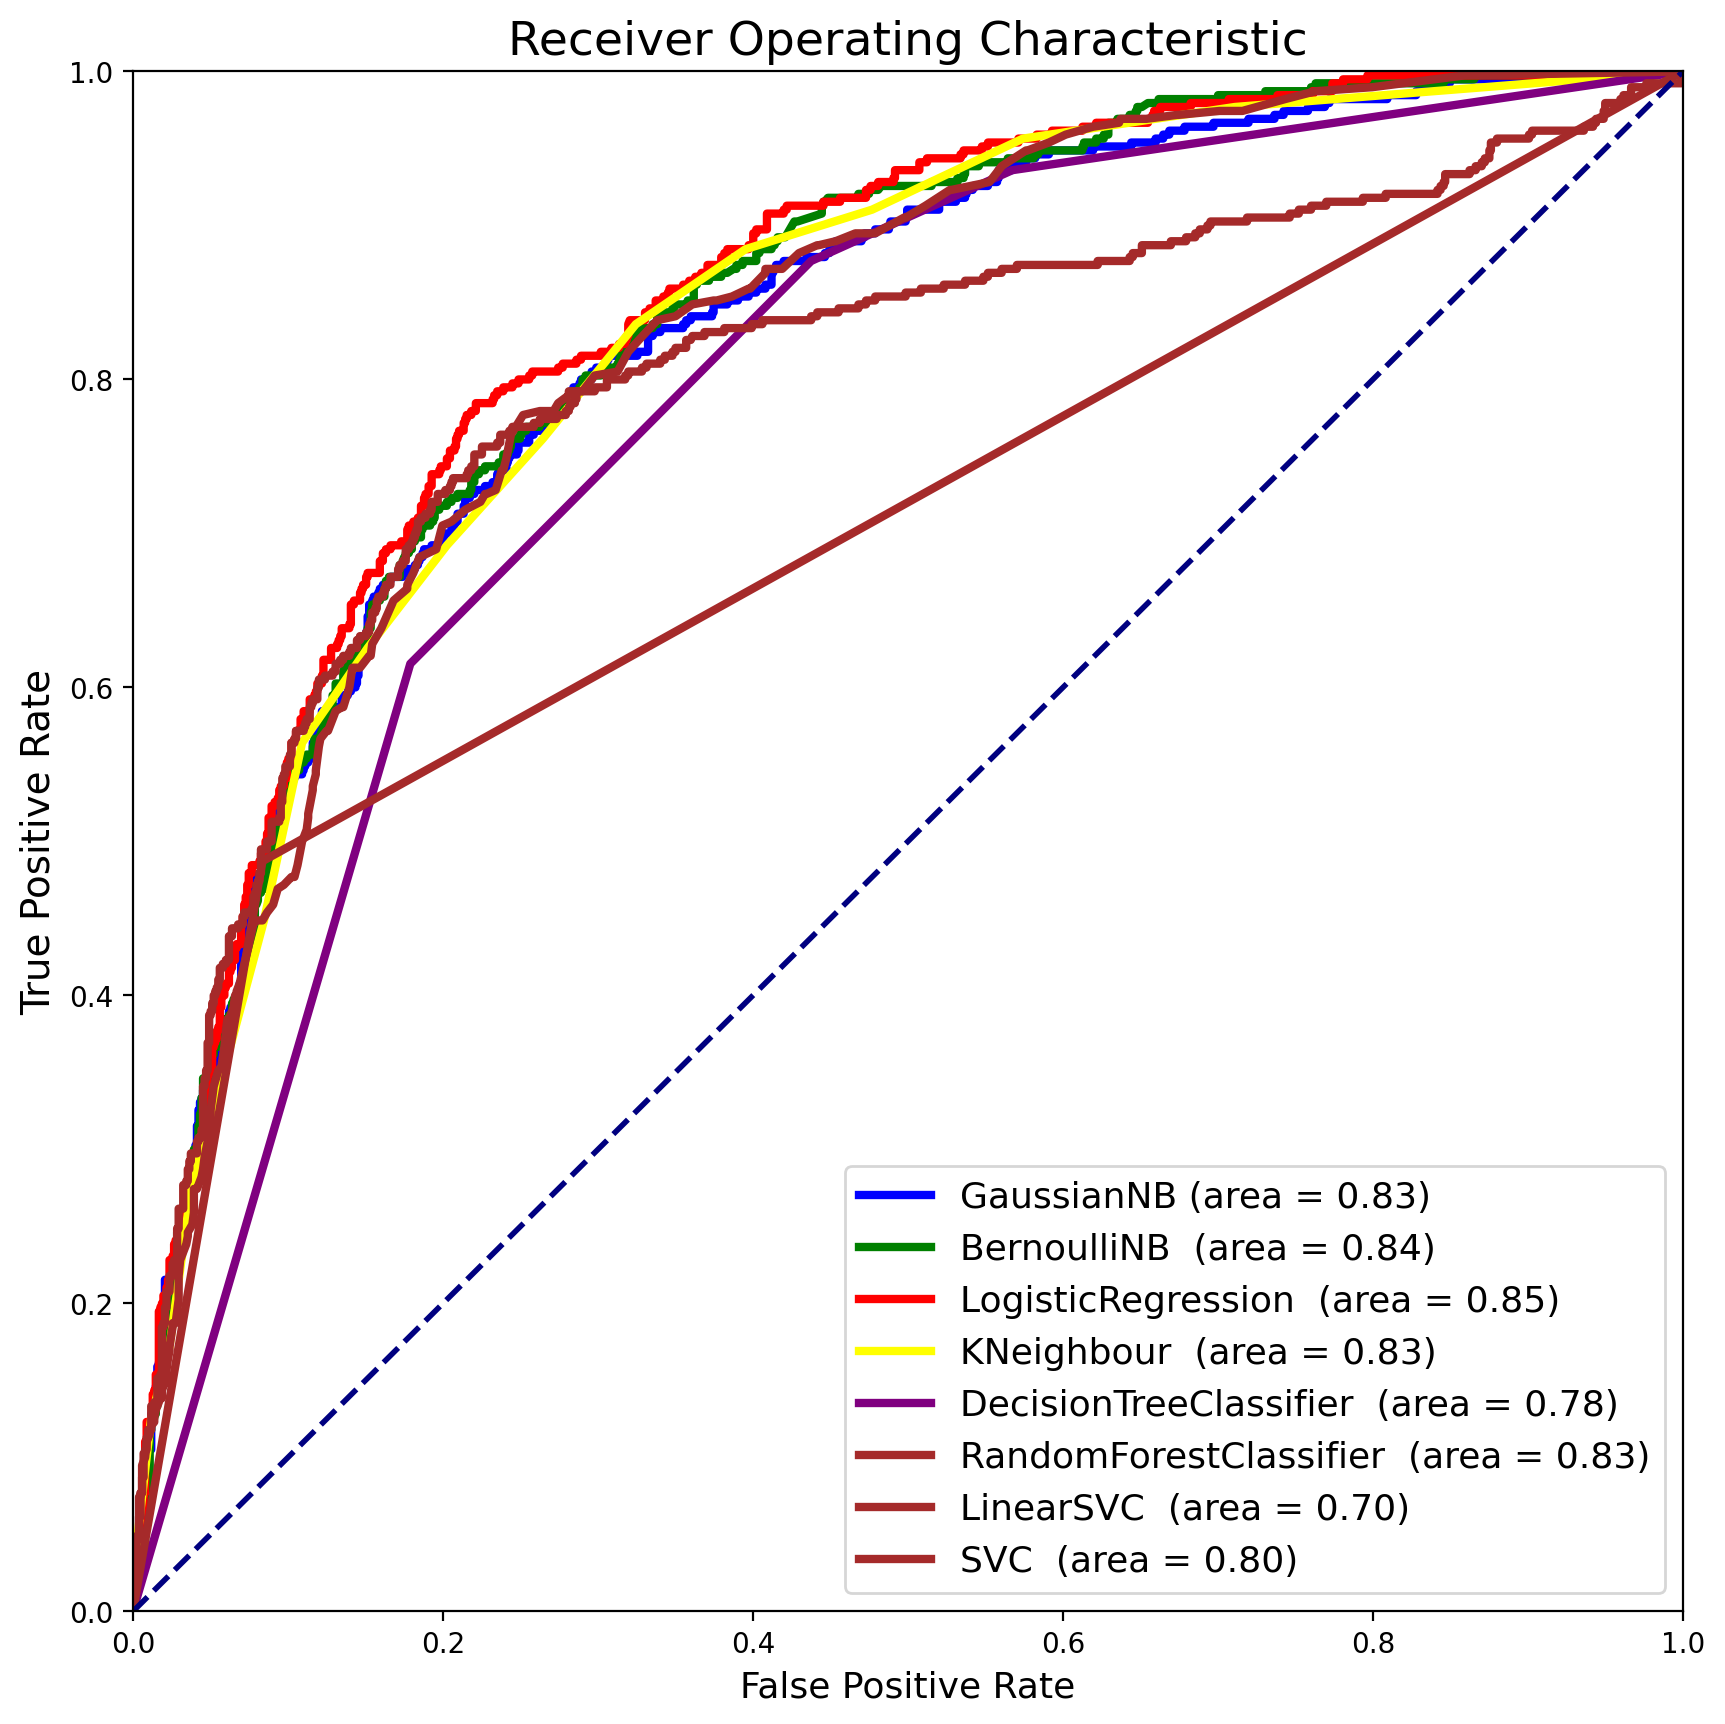

In [59]:
# plot the ROC curves
plt.figure(figsize=(10, 10))

y_pred = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "blue", lw = 3, label="GaussianNB (area = %0.2f)" % auc_list[0])

y_pred = bnb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "green", lw = 3, label="BernoulliNB  (area = %0.2f)" % auc_list[1])

y_pred = logit.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "red", lw = 3, label="LogisticRegression  (area = %0.2f)" % auc_list[2])

y_pred = knn.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "yellow", lw = 3, label="KNeighbour  (area = %0.2f)" % auc_list[3])

y_pred = decisiontree.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "purple", lw = 3, label="DecisionTreeClassifier  (area = %0.2f)" % auc_list[4])

y_pred = randomforest.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "brown", lw = 3, label="RandomForestClassifier  (area = %0.2f)" % auc_list[5])

y_pred = linearsvc.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "brown", lw = 3, label="LinearSVC  (area = %0.2f)" % auc_list[6])

y_pred = svc.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color = "brown", lw = 3, label="SVC  (area = %0.2f)" % auc_list[7])


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

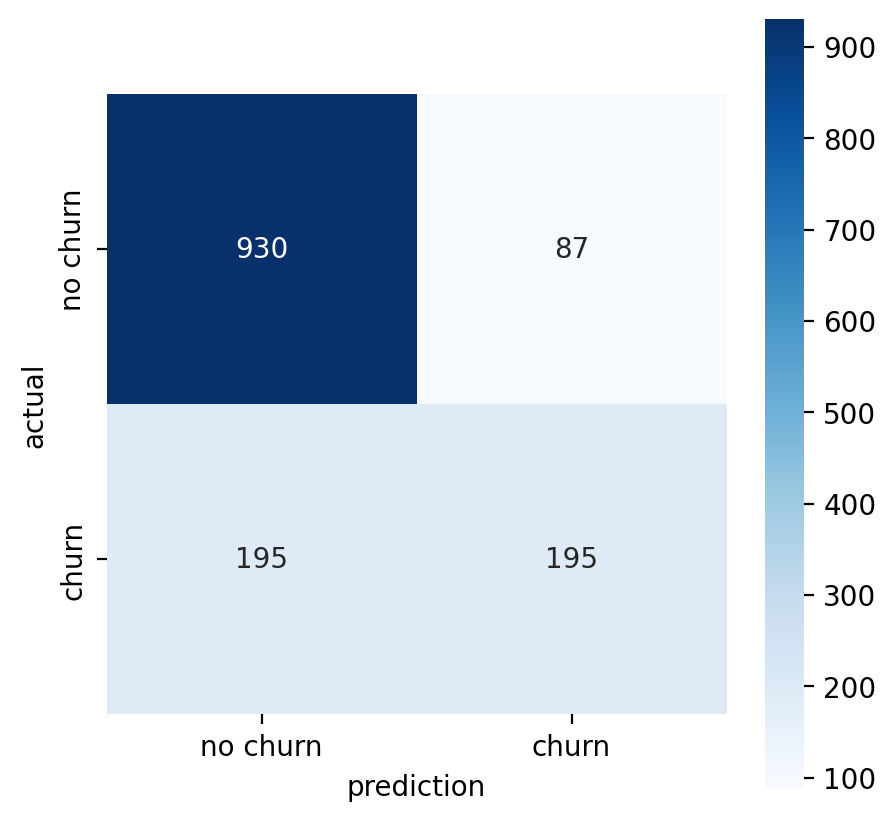

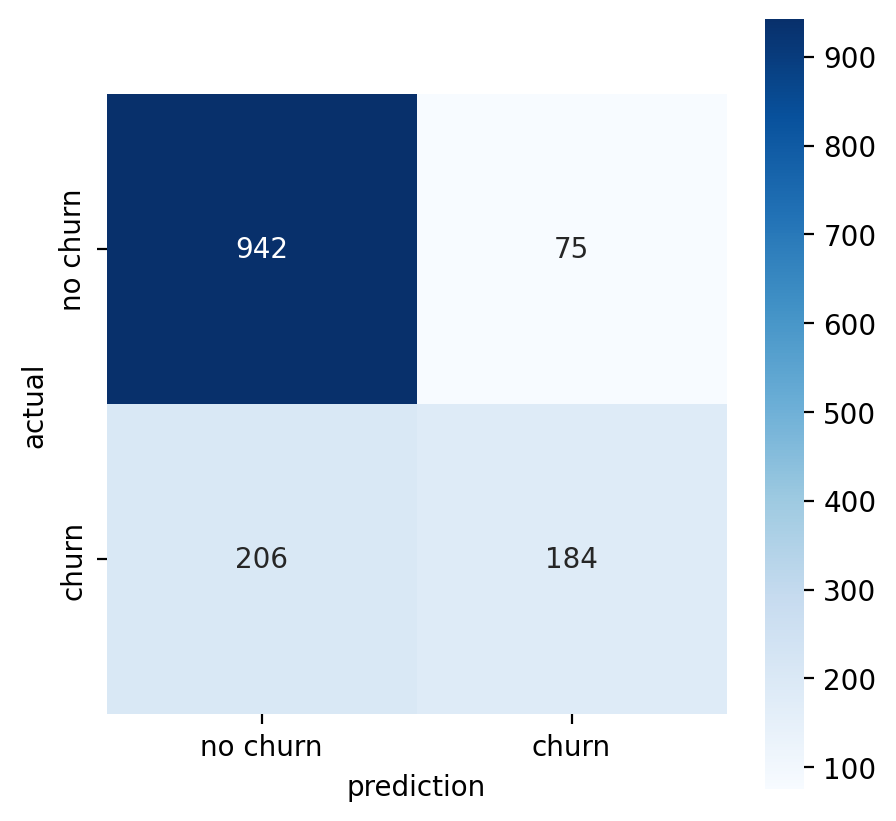

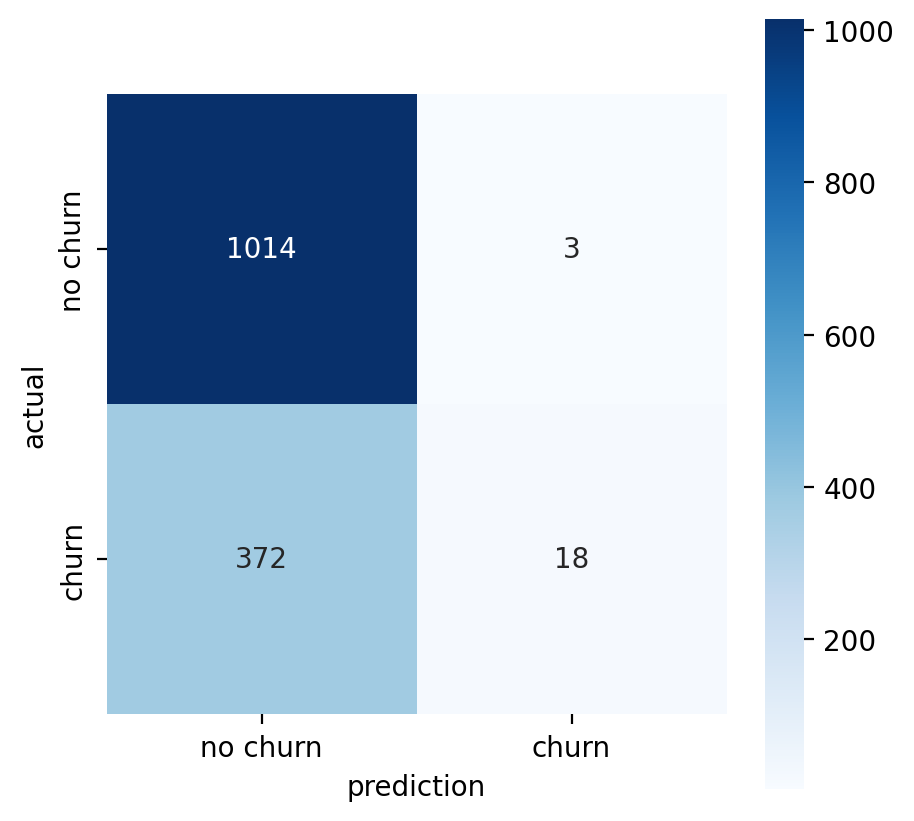

In [61]:


# see how logistic regression confusion matrix varies with threshold
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (logit.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no churn', 'churn'],
           yticklabels=['no churn', 'churn'])
    plt.xlabel('prediction')
    plt.ylabel('actual')
# Let's see how our confusion matrix changes with changes to the cutoff!
from ipywidgets import interactive, FloatSlider
logit = LogisticRegression(C = optimal_c)
logit.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.01))

